In [1]:
import deepxde as dde
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
import numpy as np

from SIRD_deepxde_DiseaseModel import SIRD_deepxde_net
from DiseaseModel import SIR,SIRD,SIRDIm,SIRDImRel, SIRDImRelSimple, SIRD2Var, SIRD2VarRelSimple, GeneralModelSolver
from Plot import Plot

# %matplotlib widget

seed = 2
np.random.seed(seed)
dde.config.set_random_seed(seed)

Using backend: pytorch



default Torch device: cpu


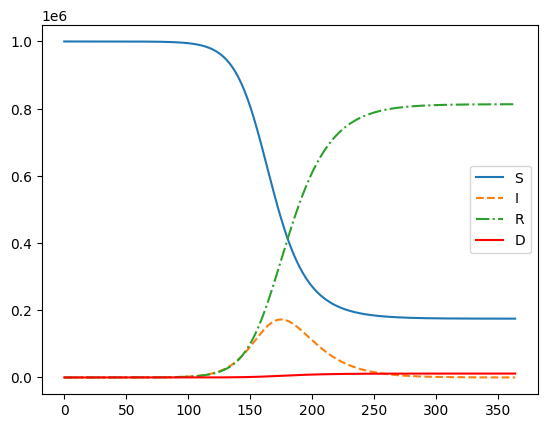

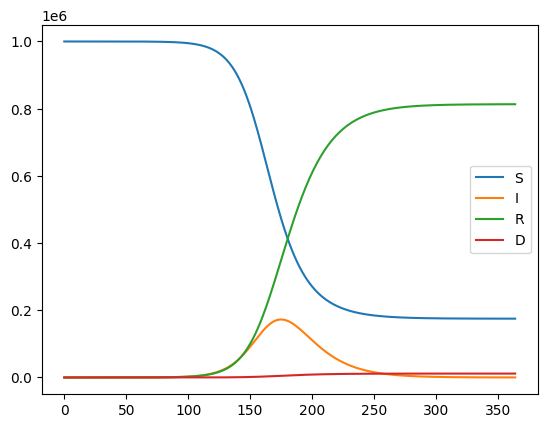

In [2]:
time_delta = [0,365] # use three values here for intro time of second variant

# initial_conditions = {
#     "S": 1000000,
#     "I": 1,
#     "R": 0,
#     }
# static_parameters = {
#     "alpha": (0.15),
#     "beta": (0.07),
#     }
# sird_model = SIR(initial_conditions, static_parameters, time_delta)

initial_conditions = {
    "S": 1000000,
    "I": 1,
    "R": 0,
    "D": 0,
    }
static_parameters = {
    "alpha": (0.15),
    "beta": (0.07),
    "gamma": (0.001),
    }
sird_model = SIRD(initial_conditions, static_parameters, time_delta)

# initial_conditions = {
#     "S": 1000000,
#     "I": 15,
#     "R": 0,
#     "D": 0,
#     "Im": 0, # should be between 0 and 1
#     }
# static_parameters = {
#     "alpha": 0.12,
#     "beta": 0.07,
#     "gamma": 0.02,
#     "kappa": 0.2,
#     }
# sird_model = SIRDIm(initial_conditions, static_parameters, time_delta)
# initial_conditions = {
#     "S": 1000000,
#     "I": 15,
#     "R": 0,
#     "D": 0,
#     "Im": 0, # should be between 0 and 1
#     }
# static_parameters = {
#     "lambda_": 1.5,
#     "gamma": 0.000,
#     "kappa": 0.2,
#     }
# sird_model = SIRDImRel(initial_conditions, static_parameters, time_delta)
# initial_conditions = {
#     "S": 1000000,
#     "I": 15,
#     "R": 0,
#     "Im": 0, # should be between 0 and 1
#     }
# static_parameters = {
#     "lambda_": 1.5,
#     "kappa": 0.2,
#     }
# sird_model = SIRDImRelSimple(initial_conditions, static_parameters, time_delta)

# initial_conditions = {
#     "S": 1000000,
#     "Ia": 1,
#     "Ib": 0,
#     "Ra": 0,
#     "Rb": 0,
#     "D": 0,
#     "Im_a": 0, # should be between 0 and 1
#     "Im_b": 0, # should be between 0 and 1
#     }
# static_parameters = {
#     "alpha_a": 0.23  ,
#     "alpha_b": 0.18,
#     "beta_a": 0.1,
#     "beta_b": 0.08,
#     "gamma_a": 0.00,
#     "gamma_b": 0.00,
#     "kappa_a": 0.8,
#     "kappa_b": 0.5,
#     }
# static_parameters = {
#     "alpha_a": 0.11,
#     "alpha_b": 0.12,
#     "beta_a": 0.08,
#     "beta_b": 0.08,
#     "gamma_a": 0.00,
#     "gamma_b": 0.00,
#     "kappa_a": 0.1,
#     "kappa_b": 0.2,
#     }
# sird_model = SIRD2Var(initial_conditions, static_parameters, time_delta)

# initial_conditions = {
#     "S": 1000000,
#     "Ia": 1,
#     "Ib": 0,
#     "Ra": 0,
#     "Rb": 0,
#     "Im_a": 0, 
#     "Im_b": 0,
#     }
# static_parameters = {
#     "lambda_a": 2.2  ,
#     "lambda_b": 1.9,
#     "kappa_a": 0.8, # should be between 0 and 1
#     "kappa_b": 0.5,
#     }

# sird_model = SIRD2VarRelSimple(initial_conditions, static_parameters, time_delta)


t_synth, solution_synth_full = sird_model.simulate()
t_synth, solution_synth = sird_model.get_solution_as_sird()
sird_model.plot_solution()
sird_model.plot_sird()


In [3]:
print(sird_model)


A Disease Model with description: 'The standard SIRD model with Susceptible, Infection, and Removed, and alpha, beta, gamma as static parameters':
Parameters:
	alpha = 0.15
	beta = 0.07
	gamma = 0.001

PDE groups and initial conditions:
	S = 1000000
	I = 1
	R = 0
	D = 0

PDE equations:
 	dS/dt = -((alpha)/N)*I*S
	dI/dt = ((alpha)/N)*S*I - (beta)*I - (gamma)*I
	dR/dt = (beta)*I 
	dD/dt = (gamma)*I
PINN PDE loss equations:
	dS_t - (-((alpha)/N)*I*S)
	dI_t - (((alpha)/N)*S*I - (beta)*I - (gamma)*I)
	dR_t - ((beta)*I )
	dD_t - ((gamma)*I)


In [4]:
# keep this even if not subsetting
t = t_synth
wsol = solution_synth

solver = GeneralModelSolver(sird_model)
# subset
# max_timestep = 300
# t_bool = t_synth < max_timestep
# t = t_synth[t_bool]
# wsol = wsol_synth[t_bool]

In [5]:
model = SIRD_deepxde_net(t, wsol,disease_model=sird_model,  model_name="diseasemodel_peak_", with_softadapt=False,
                        with_neumann=False, # important for peak prediction
                        use_ln_space=False,
                        use_ic_loss=True,
                        use_observe_loss=True,
                        use_observe_sum_loss=True,
                        use_sign_loss=False,
                        use_smooth_loss=False,
                        use_initL1_loss=False,
                        use_infectedL1_loss=False,)
print(model)
hyper_print_every = 2000
static_loss_weights = []
for key in (model.PDE_names + list(model.loss_points_dict.keys())):
    if "d" in key and "_t" in key:
        w = 2
    else:
        w = 0.2
    static_loss_weights.append(w)
model.init_model(lr=0.01, print_every=hyper_print_every, activation="tanh", loss="MSE", nn_layers=2, nn_layer_width=32, loss_weights=static_loss_weights)




PINN model:
Parameters: ['alpha', 'beta', 'gamma']
Loss measures: ['dS_t ', 'dI_t ', 'dR_t ', 'dD_t ', 'ic_S', 'observe_S', 'observe_I', 'observe_R', 'observe_D', 'observe_SUM']
Compiling model...
'compile' took 0.000063 s



In [6]:
# prev_best_step = 0
# iters = 0


In [7]:
def intermediate_train(plot_every=hyper_print_every, reset=False):
    TOTAL_ITER = 100_000
    iters = 0
    if not hasattr(intermediate_train, "prev_best_step") or reset:
        setattr(intermediate_train, "prev_best_step", 0)
    try:
        while True:
            iters += plot_every
            # for n in range(TOTAL_ITER//plot_every):
            model.train_model(iterations=plot_every, print_every=hyper_print_every, use_LBFGSB=False)
            params_nn, best_step = model.get_best_train_step() # TODO make a get_best_step function
            if best_step > intermediate_train.prev_best_step:
                setattr(intermediate_train, "prev_best_step", best_step)
                break
            elif iters >= TOTAL_ITER:
                break
    except KeyboardInterrupt:
        print("Training ended prematurely")

    params_nn, best_step = model.get_best_params() 
    print(static_parameters, sep="\n")
    t_nn_param, wsol_nn_param, wsol_sird_nn_param = solver(*params_nn)
    # params_nn= tuple(np.exp([*params_nn]))
    # print(*params_nn)
    model.set_synthetic_data(t_synth, solution_synth_full) 
    model.set_nn_synthetic_data(t_nn_param, wsol_nn_param, wsol_sird_nn_param)
    plot = Plot(model, values_to_plot=sird_model.initial_conditions_keys) # class that contains plotting functions
    plot.show_known_and_prediction()


# plot.plot_param_history()
# plot.plot_loss_history()


Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.40e-01, 3.85e-02, 4.66e-02, 1.41e-03, 2.00e-01, 1.70e-01, 3.45e-01, 6.93e-01, 3.26e-01, 2.58e+00]    [1.40e-01, 3.85e-02, 4.66e-02, 1.41e-03, 2.00e-01, 1.70e-01, 3.45e-01, 6.93e-01, 3.26e-01, 2.58e+00]    []  
2000      [2.60e-06, 1.01e-06, 1.67e-06, 1.74e-07, 9.15e-10, 8.61e-06, 2.18e-05, 2.59e-05, 2.53e-06, 1.46e-06]    [2.60e-06, 1.01e-06, 1.67e-06, 1.74e-07, 9.15e-10, 8.61e-06, 2.18e-05, 2.59e-05, 2.53e-06, 1.46e-06]    []  

Best model at step 1995:
  train loss: 6.39e-05
  test loss: 6.39e-05
  test metric: []

'train' took 16.706291 s

Best train step: 1995
alpha: 0.11857964098
beta: 0.065021283925
gamma: -0.0025561451912
Best train step: 1995
alpha: 0.11857964098
beta: 0.065021283925
gamma: -0.0025561451912
{'alpha': 0.1

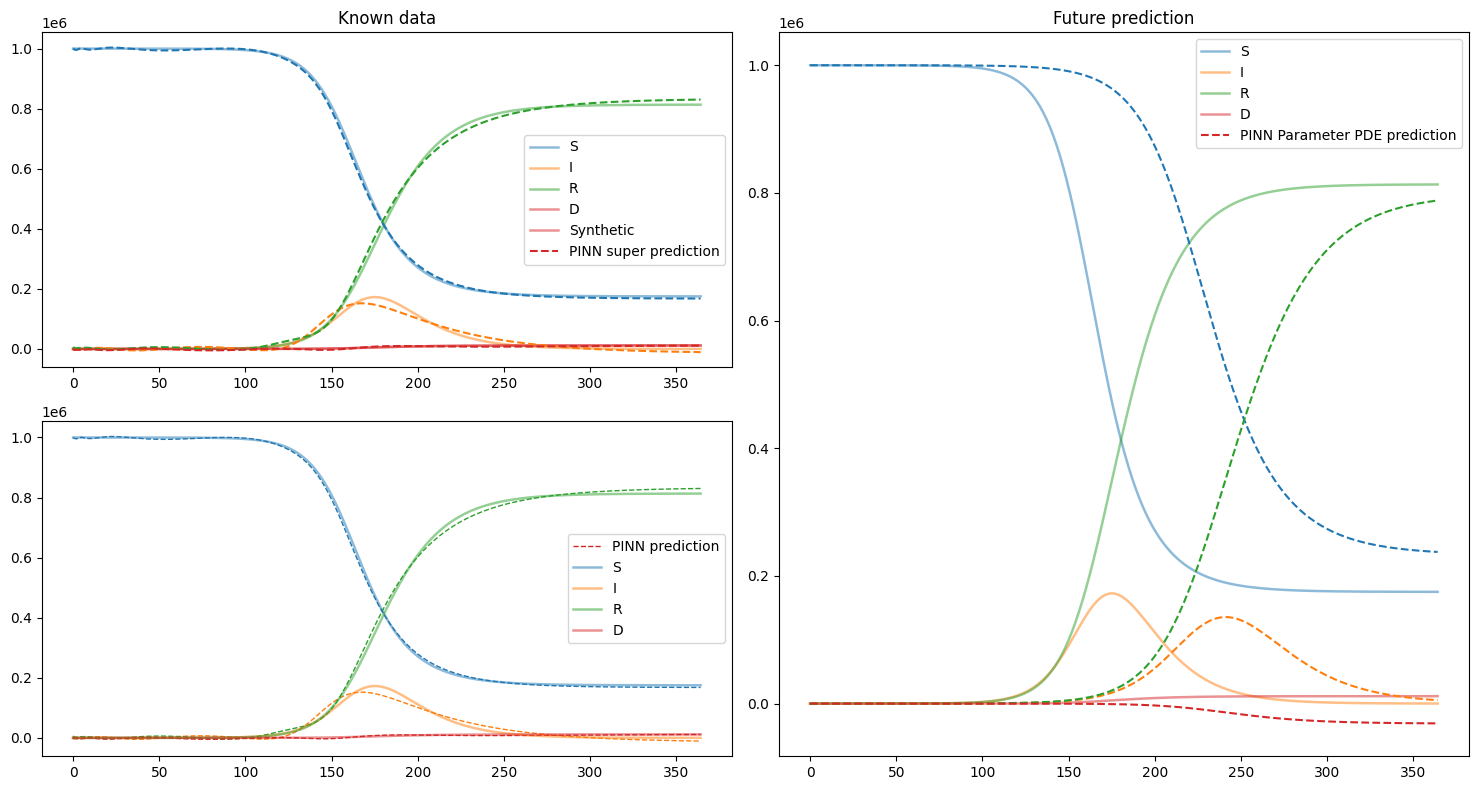

In [8]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
2000      [2.60e-06, 1.01e-06, 1.67e-06, 1.74e-07, 9.15e-10, 8.61e-06, 2.18e-05, 2.59e-05, 2.53e-06, 1.46e-06]    [2.60e-06, 1.01e-06, 1.67e-06, 1.74e-07, 9.15e-10, 8.61e-06, 2.18e-05, 2.59e-05, 2.53e-06, 1.46e-06]    []  
4000      [6.42e-07, 3.30e-07, 5.72e-07, 7.73e-08, 3.93e-08, 3.20e-05, 1.17e-05, 7.27e-05, 1.15e-05, 8.82e-05]    [6.42e-07, 3.30e-07, 5.72e-07, 7.73e-08, 3.93e-08, 3.20e-05, 1.17e-05, 7.27e-05, 1.15e-05, 8.82e-05]    []  

Best model at step 3720:
  train loss: 9.21e-06
  test loss: 9.21e-06
  test metric: []

'train' took 15.736878 s

Best train step: 3720
alpha: 0.14210136235
beta: 0.068480908871
gamma: 0.00048473192146
Best train step: 3720
alpha: 0.14210136235
beta: 0.068480908871
gamma: 0.00048473192146
{'alpha': 0.1

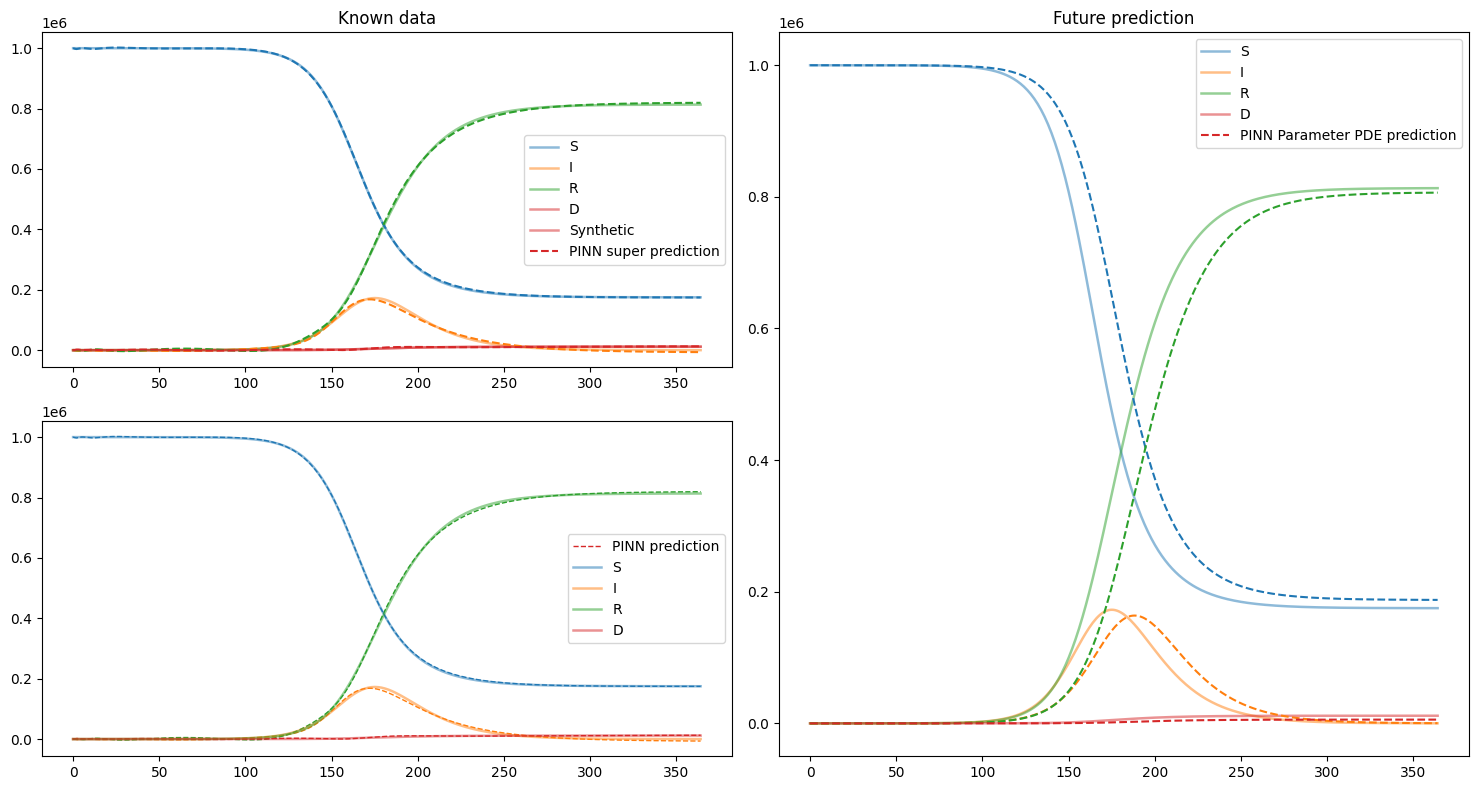

In [9]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
4000      [6.42e-07, 3.30e-07, 5.72e-07, 7.73e-08, 3.93e-08, 3.20e-05, 1.17e-05, 7.27e-05, 1.15e-05, 8.82e-05]    [6.42e-07, 3.30e-07, 5.72e-07, 7.73e-08, 3.93e-08, 3.20e-05, 1.17e-05, 7.27e-05, 1.15e-05, 8.82e-05]    []  
6000      [2.81e-07, 1.21e-07, 2.41e-07, 4.07e-08, 2.19e-06, 2.67e-05, 3.06e-06, 2.02e-05, 2.06e-06, 9.91e-07]    [2.81e-07, 1.21e-07, 2.41e-07, 4.07e-08, 2.19e-06, 2.67e-05, 3.06e-06, 2.02e-05, 2.06e-06, 9.91e-07]    []  

Best model at step 5449:
  train loss: 2.62e-06
  test loss: 2.62e-06
  test metric: []

'train' took 15.697056 s

Best train step: 5449
alpha: 0.14553487301
beta: 0.069139689207
gamma: 0.00042250813567
Best train step: 5449
alpha: 0.14553487301
beta: 0.069139689207
gamma: 0.00042250813567
{'alpha': 0.1

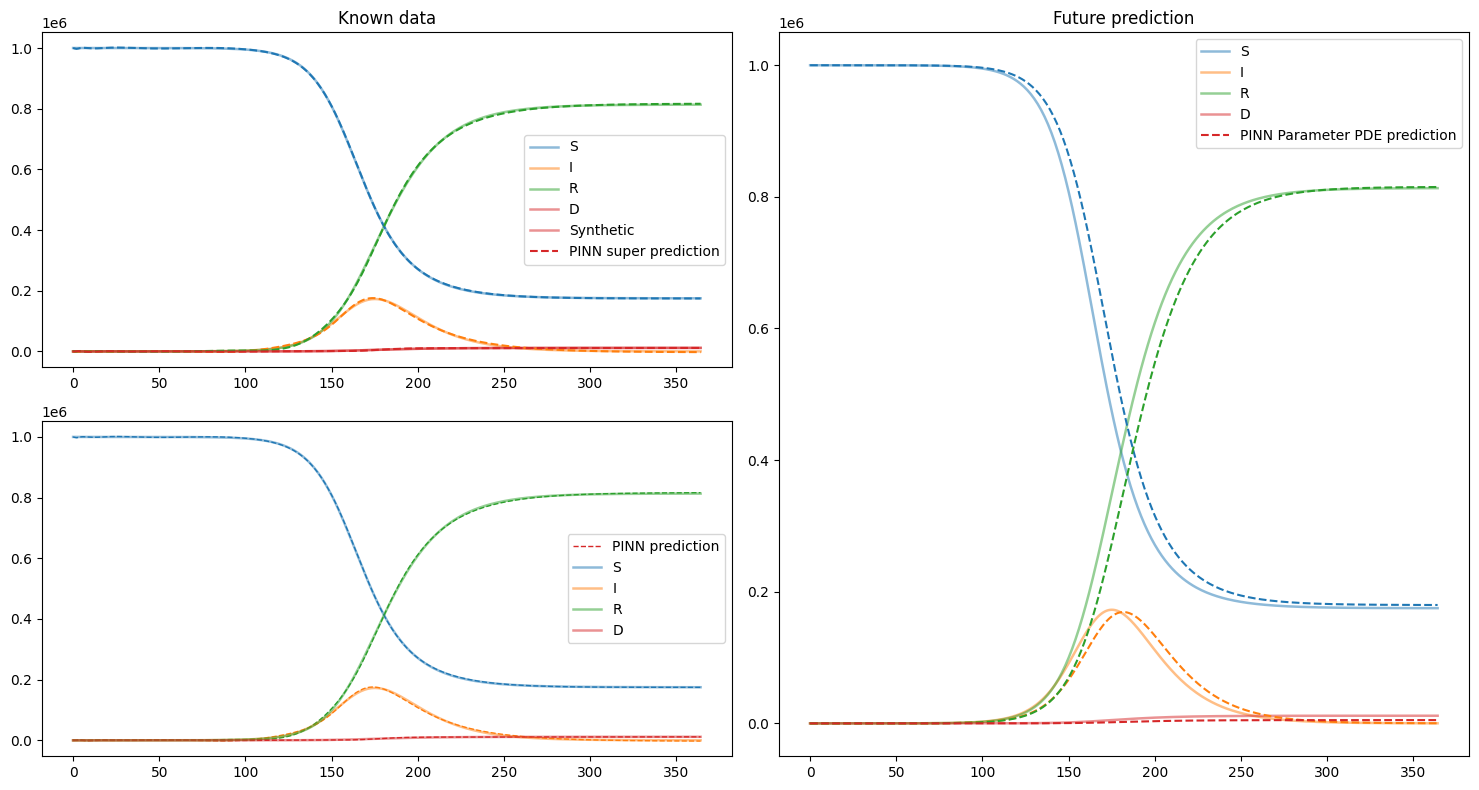

In [10]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
6000      [2.81e-07, 1.21e-07, 2.41e-07, 4.07e-08, 2.19e-06, 2.67e-05, 3.06e-06, 2.02e-05, 2.06e-06, 9.91e-07]    [2.81e-07, 1.21e-07, 2.41e-07, 4.07e-08, 2.19e-06, 2.67e-05, 3.06e-06, 2.02e-05, 2.06e-06, 9.91e-07]    []  
8000      [4.29e-06, 1.25e-06, 2.27e-06, 1.32e-07, 3.06e-07, 1.15e-04, 3.94e-05, 2.63e-05, 2.70e-05, 3.84e-04]    [4.29e-06, 1.25e-06, 2.27e-06, 1.32e-07, 3.06e-07, 1.15e-04, 3.94e-05, 2.63e-05, 2.70e-05, 3.84e-04]    []  

Best model at step 7947:
  train loss: 2.10e-06
  test loss: 2.10e-06
  test metric: []

'train' took 16.439587 s

Best train step: 7947
alpha: 0.14977683127
beta: 0.069922968745
gamma: 0.00093094492331
Best train step: 7947
alpha: 0.14977683127
beta: 0.069922968745
gamma: 0.00093094492331
{'alpha': 0.1

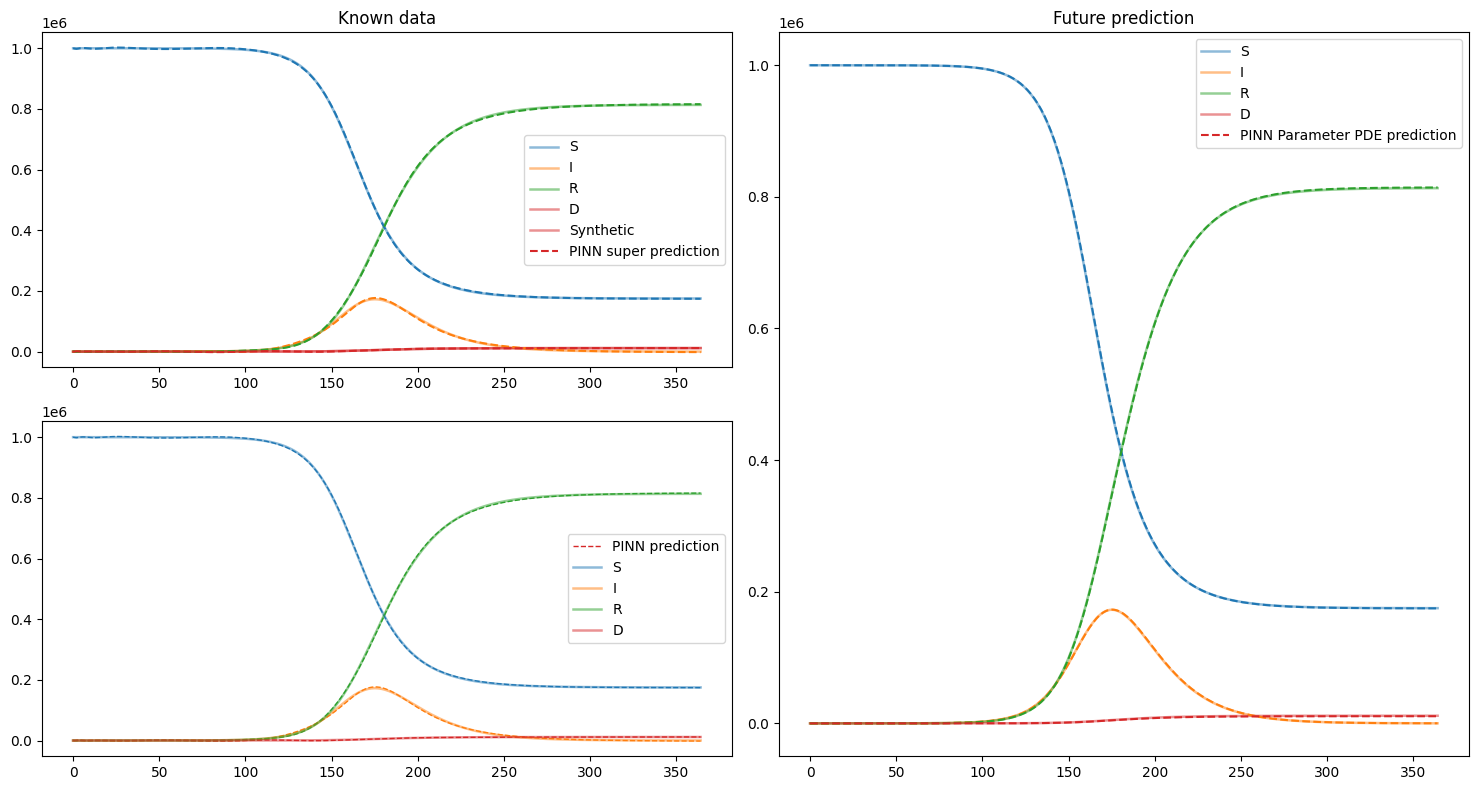

In [11]:
intermediate_train()

## Peak Prediction

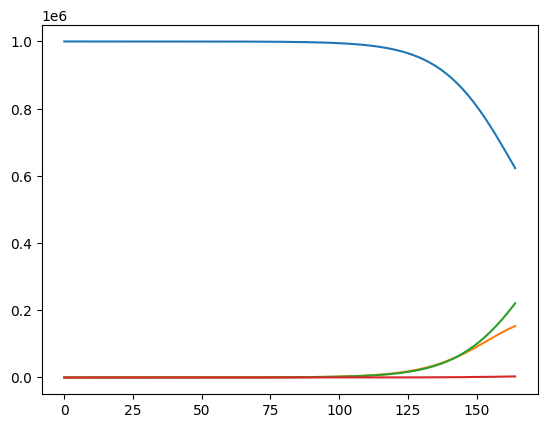

In [12]:
# keep this even if not subsetting
# t = t_synth
# wsol = solution_synth

solver = GeneralModelSolver(sird_model)
# subset
max_timestep = 165
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = solution_synth[t_bool]
plt.plot(t, wsol)

In [13]:
model = SIRD_deepxde_net(t, wsol,disease_model=sird_model, model_name="diseasemodel_peakprediction", with_softadapt=False,
                        with_neumann=False, # important for peak prediction
                        use_ln_space=False,
                        use_ic_loss=True,
                        use_observe_loss=True,
                        use_observe_sum_loss=True,
                        use_sign_loss=False,
                        use_smooth_loss=False,
                        use_initL1_loss=False,
                        use_infectedL1_loss=False,)
                        
print(model)
hyper_print_every = 2000
best_step = 0
static_loss_weights = []
for key in (model.PDE_names + list(model.loss_points_dict.keys())):
    if "d" in key and "_t" in key:
    # if "neumann" in key:
        w = 2
    else:
        w = 0.2
    static_loss_weights.append(w)

model.init_model(lr=0.01, print_every=hyper_print_every, activation="tanh", loss="MSE", nn_layers=2, nn_layer_width=32, loss_weights=static_loss_weights)




PINN model:
Parameters: ['alpha', 'beta', 'gamma']
Loss measures: ['dS_t ', 'dI_t ', 'dR_t ', 'dD_t ', 'ic_S', 'observe_S', 'observe_I', 'observe_R', 'observe_D', 'observe_SUM']
Compiling model...
'compile' took 0.000056 s



Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [6.17e-03, 7.22e-02, 2.61e-02, 2.28e-03, 2.00e-01, 3.25e-01, 2.77e-01, 1.13e-02, 1.81e-03, 1.36e+00]    [6.17e-03, 7.22e-02, 2.61e-02, 2.28e-03, 2.00e-01, 3.25e-01, 2.77e-01, 1.13e-02, 1.81e-03, 1.36e+00]    []  
2000      [2.14e-06, 6.94e-07, 7.33e-07, 1.90e-07, 8.66e-08, 8.29e-05, 1.64e-05, 1.89e-05, 1.13e-06, 2.47e-06]    [2.14e-06, 6.94e-07, 7.33e-07, 1.90e-07, 8.66e-08, 8.29e-05, 1.64e-05, 1.89e-05, 1.13e-06, 2.47e-06]    []  

Best model at step 1998:
  train loss: 1.19e-04
  test loss: 1.19e-04
  test metric: []

'train' took 11.469735 s

Best train step: 1998
alpha: 0.08456017077
beta: 0.042453870177
gamma: -0.00336496206
Best train step: 1998
alpha: 0.08456017077
beta: 0.042453870177
gamma: -0.00336496206
{'alpha': 0.15, '

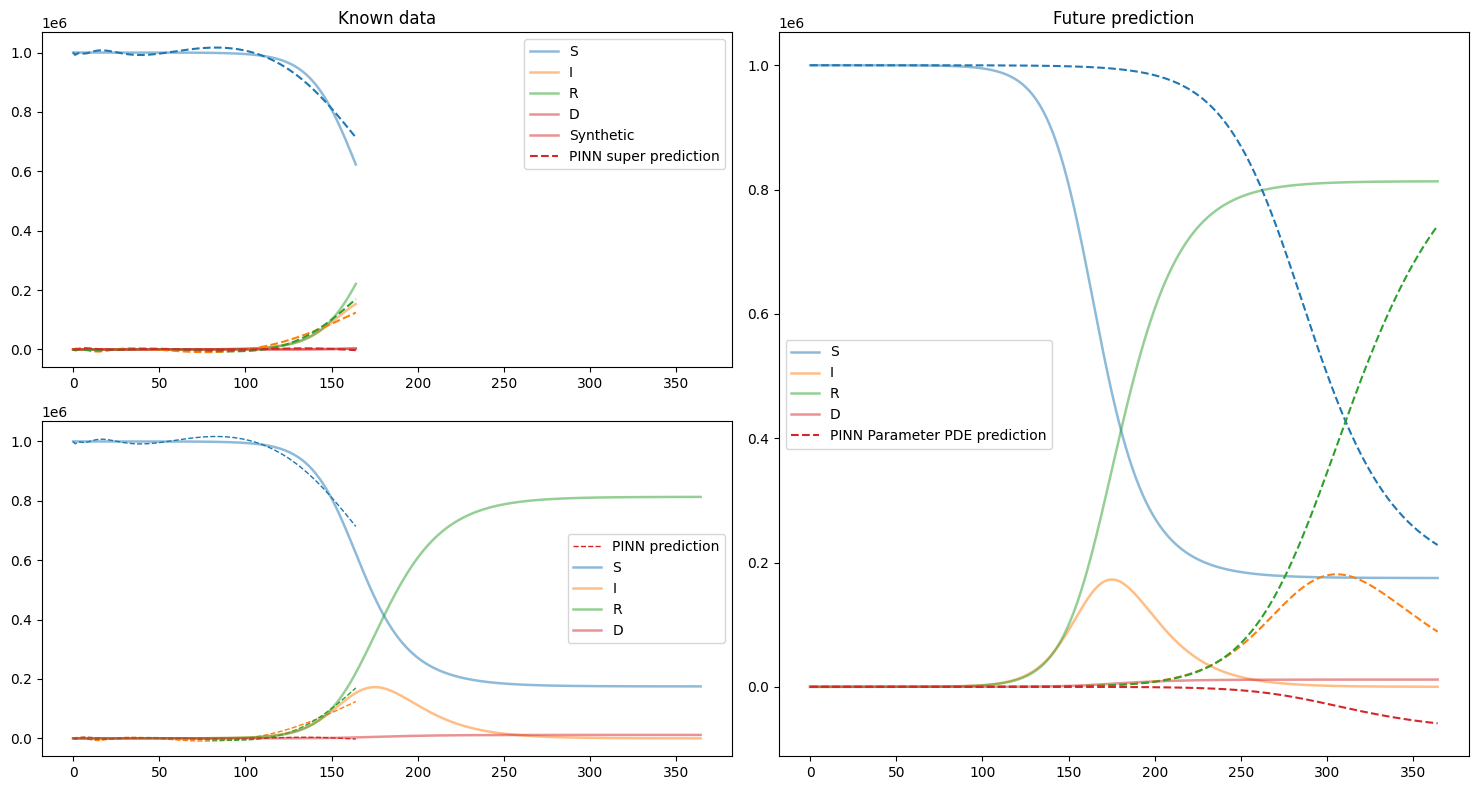

In [14]:
intermediate_train(reset=True)

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
2000      [2.14e-06, 6.94e-07, 7.33e-07, 1.90e-07, 8.66e-08, 8.29e-05, 1.64e-05, 1.89e-05, 1.13e-06, 2.47e-06]    [2.14e-06, 6.94e-07, 7.33e-07, 1.90e-07, 8.66e-08, 8.29e-05, 1.64e-05, 1.89e-05, 1.13e-06, 2.47e-06]    []  
4000      [2.37e-06, 8.32e-07, 8.78e-07, 2.06e-07, 2.10e-07, 1.13e-04, 1.84e-05, 4.60e-05, 3.06e-07, 1.18e-06]    [2.37e-06, 8.32e-07, 8.78e-07, 2.06e-07, 2.10e-07, 1.13e-04, 1.84e-05, 4.60e-05, 3.06e-07, 1.18e-06]    []  

Best model at step 2136:
  train loss: 9.32e-05
  test loss: 9.32e-05
  test metric: []

'train' took 11.264028 s

Best train step: 2136
alpha: 0.089903831482
beta: 0.045177780092
gamma: -0.0034304116853
Best train step: 2136
alpha: 0.089903831482
beta: 0.045177780092
gamma: -0.0034304116853
{'alpha': 0

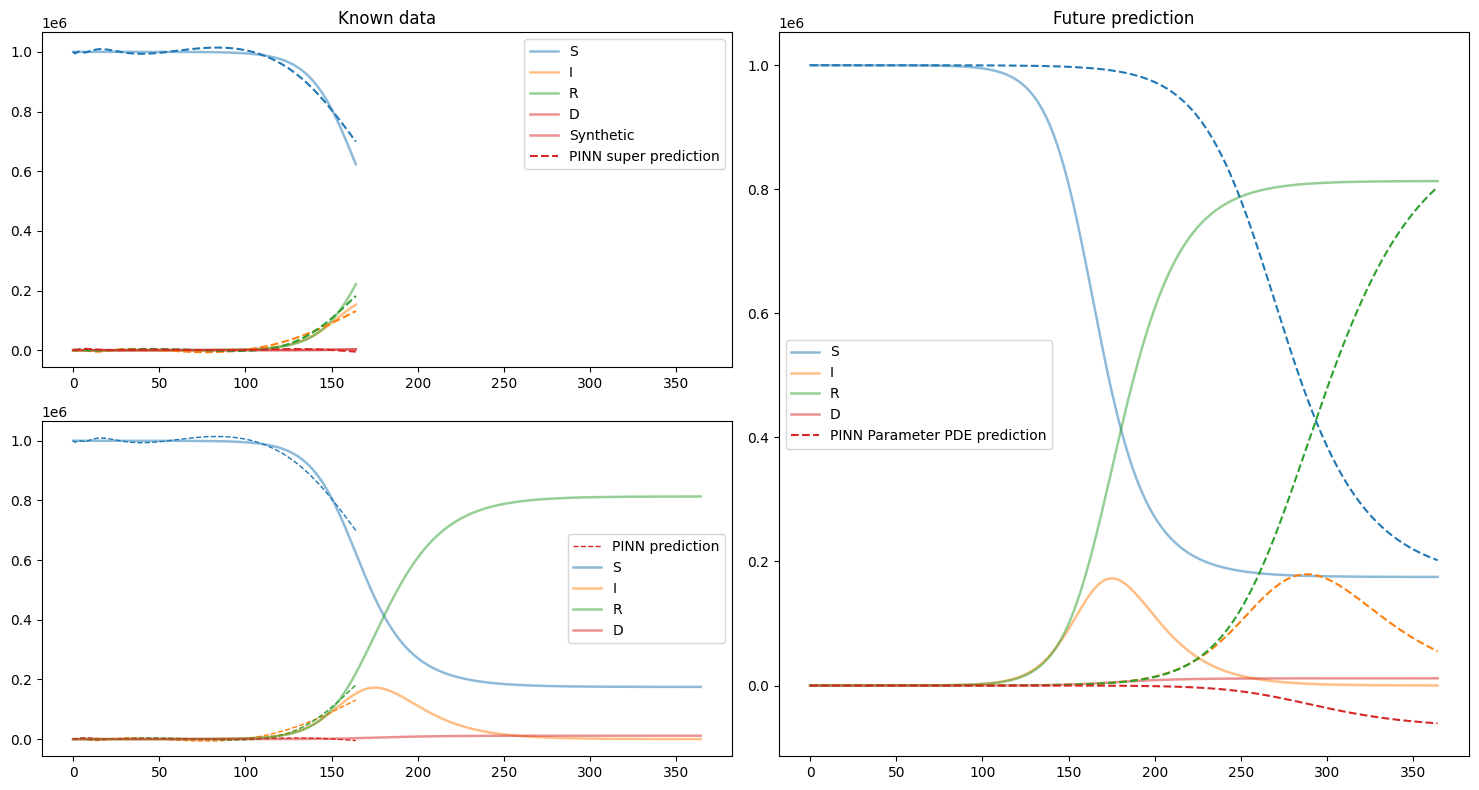

In [15]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
4000      [2.37e-06, 8.32e-07, 8.78e-07, 2.06e-07, 2.10e-07, 1.13e-04, 1.84e-05, 4.60e-05, 3.06e-07, 1.18e-06]    [2.37e-06, 8.32e-07, 8.78e-07, 2.06e-07, 2.10e-07, 1.13e-04, 1.84e-05, 4.60e-05, 3.06e-07, 1.18e-06]    []  
6000      [6.06e-06, 2.48e-06, 1.88e-06, 6.34e-07, 1.50e-05, 8.74e-05, 2.37e-05, 2.00e-05, 2.48e-05, 5.01e-04]    [6.06e-06, 2.48e-06, 1.88e-06, 6.34e-07, 1.50e-05, 8.74e-05, 2.37e-05, 2.00e-05, 2.48e-05, 5.01e-04]    []  

Best model at step 5937:
  train loss: 9.56e-06
  test loss: 9.56e-06
  test metric: []

'train' took 11.729526 s

Best train step: 5937
alpha: 0.13238967955
beta: 0.058312781155
gamma: 0.0040574637242
Best train step: 5937
alpha: 0.13238967955
beta: 0.058312781155
gamma: 0.0040574637242
{'alpha': 0.15,

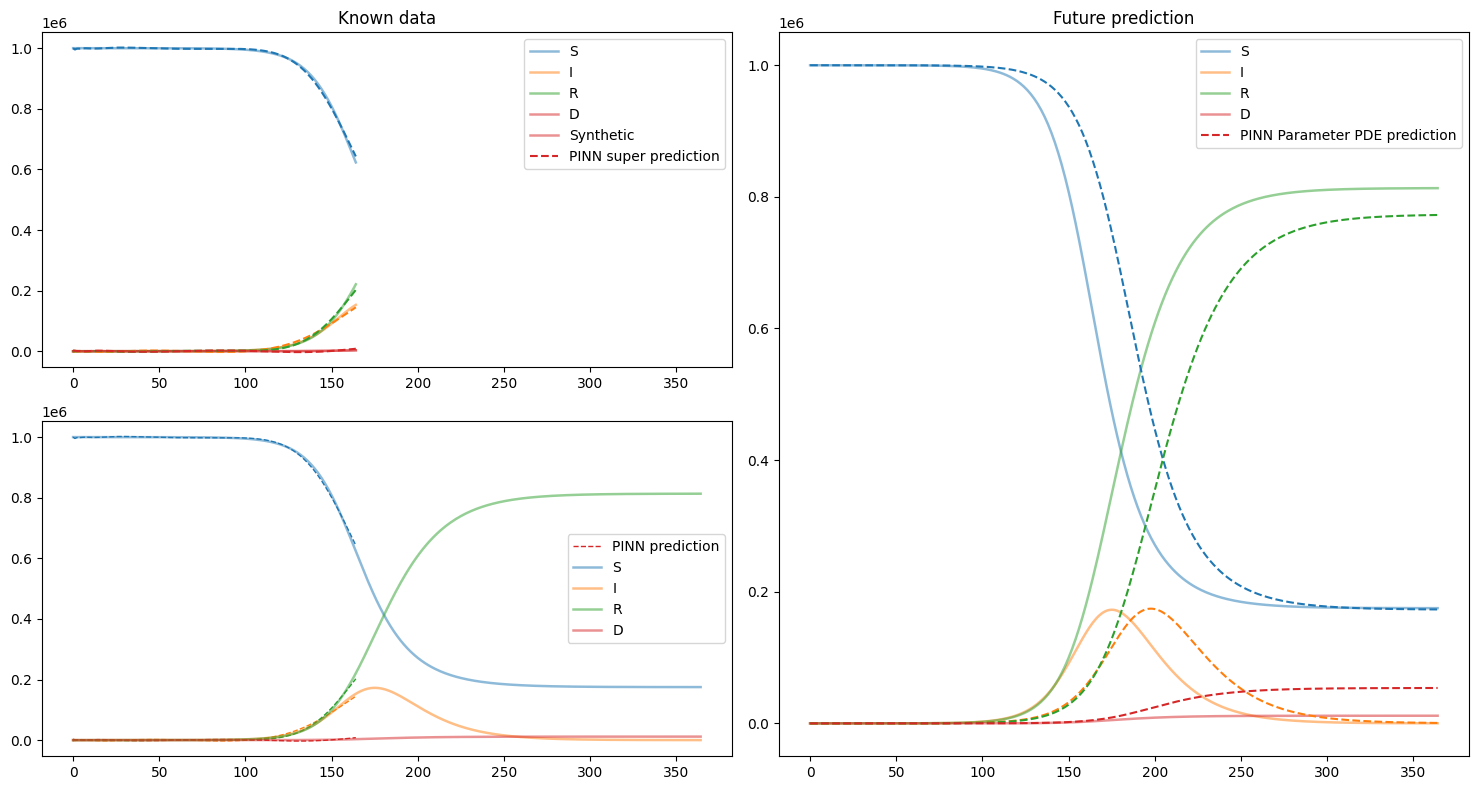

In [16]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
6000      [6.06e-06, 2.48e-06, 1.88e-06, 6.34e-07, 1.50e-05, 8.74e-05, 2.37e-05, 2.00e-05, 2.48e-05, 5.01e-04]    [6.06e-06, 2.48e-06, 1.88e-06, 6.34e-07, 1.50e-05, 8.74e-05, 2.37e-05, 2.00e-05, 2.48e-05, 5.01e-04]    []  
8000      [1.27e-06, 4.78e-07, 5.47e-07, 1.33e-07, 3.03e-07, 8.91e-06, 1.03e-05, 1.28e-05, 4.43e-06, 5.26e-05]    [1.27e-06, 4.78e-07, 5.47e-07, 1.33e-07, 3.03e-07, 8.91e-06, 1.03e-05, 1.28e-05, 4.43e-06, 5.26e-05]    []  

Best model at step 7842:
  train loss: 2.09e-06
  test loss: 2.09e-06
  test metric: []

'train' took 11.496396 s

Best train step: 7842
alpha: 0.14250287414
beta: 0.063681967556
gamma: -0.00099150137976
Best train step: 7842
alpha: 0.14250287414
beta: 0.063681967556
gamma: -0.00099150137976
{'alpha': 0

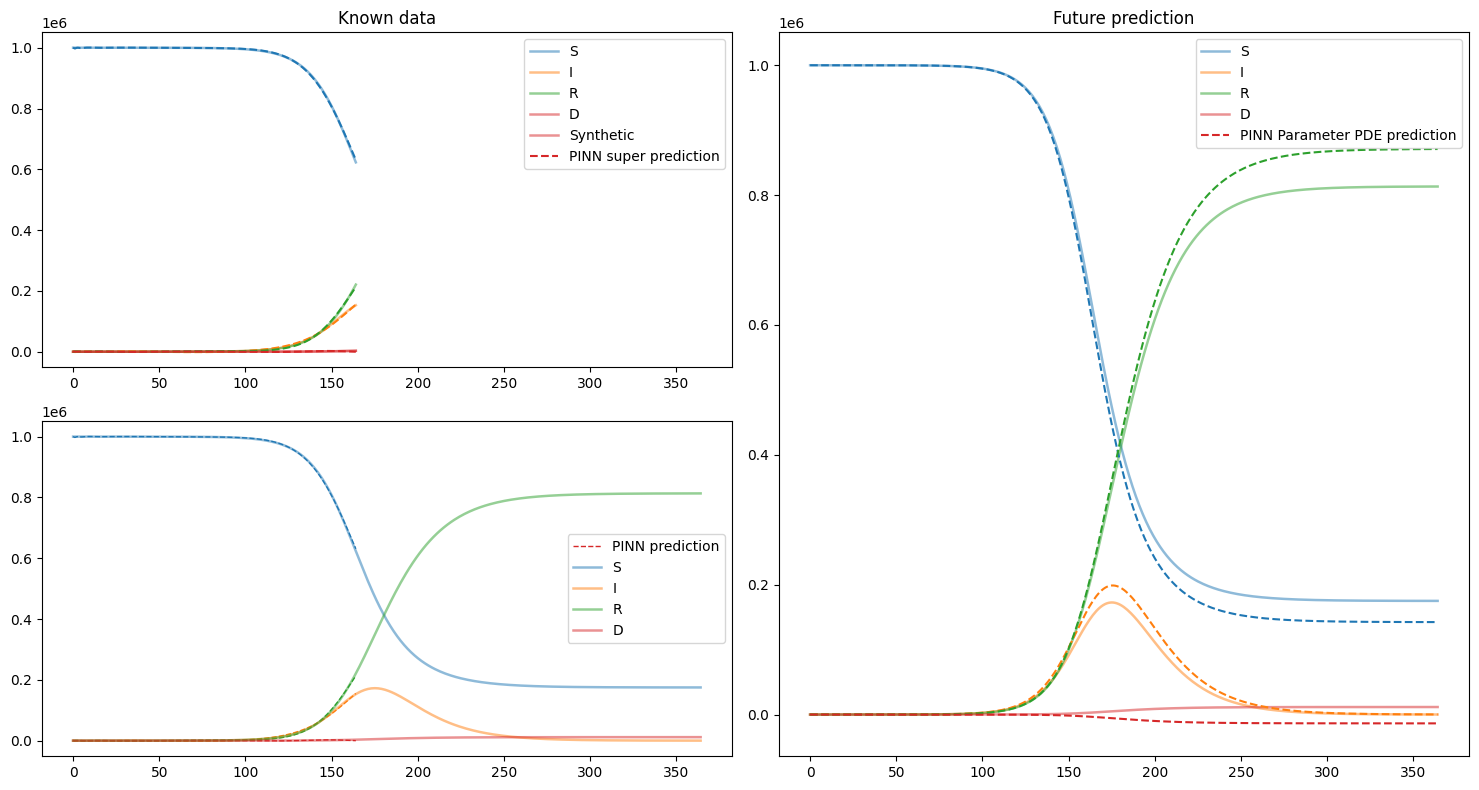

In [17]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
8000      [1.27e-06, 4.78e-07, 5.47e-07, 1.33e-07, 3.03e-07, 8.91e-06, 1.03e-05, 1.28e-05, 4.43e-06, 5.26e-05]    [1.27e-06, 4.78e-07, 5.47e-07, 1.33e-07, 3.03e-07, 8.91e-06, 1.03e-05, 1.28e-05, 4.43e-06, 5.26e-05]    []  
10000     [5.51e-07, 1.25e-07, 5.76e-07, 6.17e-08, 1.33e-06, 8.54e-06, 2.08e-06, 3.18e-06, 4.46e-07, 1.83e-07]    [5.51e-07, 1.25e-07, 5.76e-07, 6.17e-08, 1.33e-06, 8.54e-06, 2.08e-06, 3.18e-06, 4.46e-07, 1.83e-07]    []  

Best model at step 7842:
  train loss: 2.09e-06
  test loss: 2.09e-06
  test metric: []

'train' took 11.933145 s

Best train step: 7842
alpha: 0.14250287414
beta: 0.063681967556
gamma: -0.00099150137976
Training model...

Step      Train loss                                                             

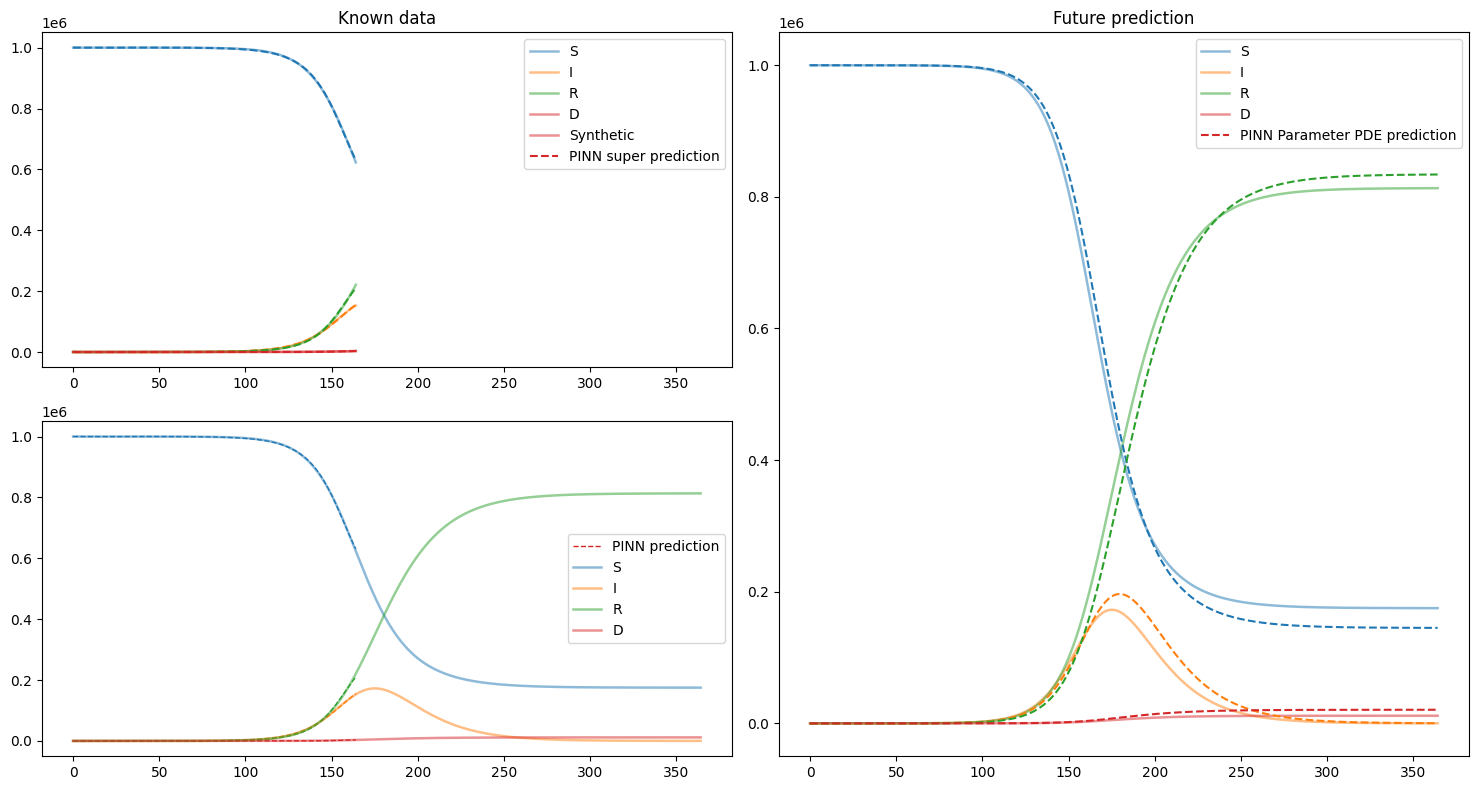

In [18]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
46000     [3.21e-06, 1.78e-06, 8.46e-07, 5.69e-08, 2.17e-05, 4.90e-05, 1.35e-05, 1.40e-05, 2.03e-05, 3.17e-04]    [3.21e-06, 1.78e-06, 8.46e-07, 5.69e-08, 2.17e-05, 4.90e-05, 1.35e-05, 1.40e-05, 2.03e-05, 3.17e-04]    []  
48000     [1.41e-06, 1.69e-07, 9.11e-07, 2.46e-08, 6.43e-06, 1.47e-05, 1.79e-06, 3.83e-06, 1.68e-06, 3.31e-05]    [1.41e-06, 1.69e-07, 9.11e-07, 2.46e-08, 6.43e-06, 1.47e-05, 1.79e-06, 3.83e-06, 1.68e-06, 3.31e-05]    []  

Best model at step 47522:
  train loss: 1.80e-06
  test loss: 1.80e-06
  test metric: []

'train' took 11.236946 s

Best train step: 47522
alpha: 0.1394687742
beta: 0.060069516301
gamma: 0.0016179349041
Best train step: 47522
alpha: 0.1394687742
beta: 0.060069516301
gamma: 0.0016179349041
{'alpha': 0.15

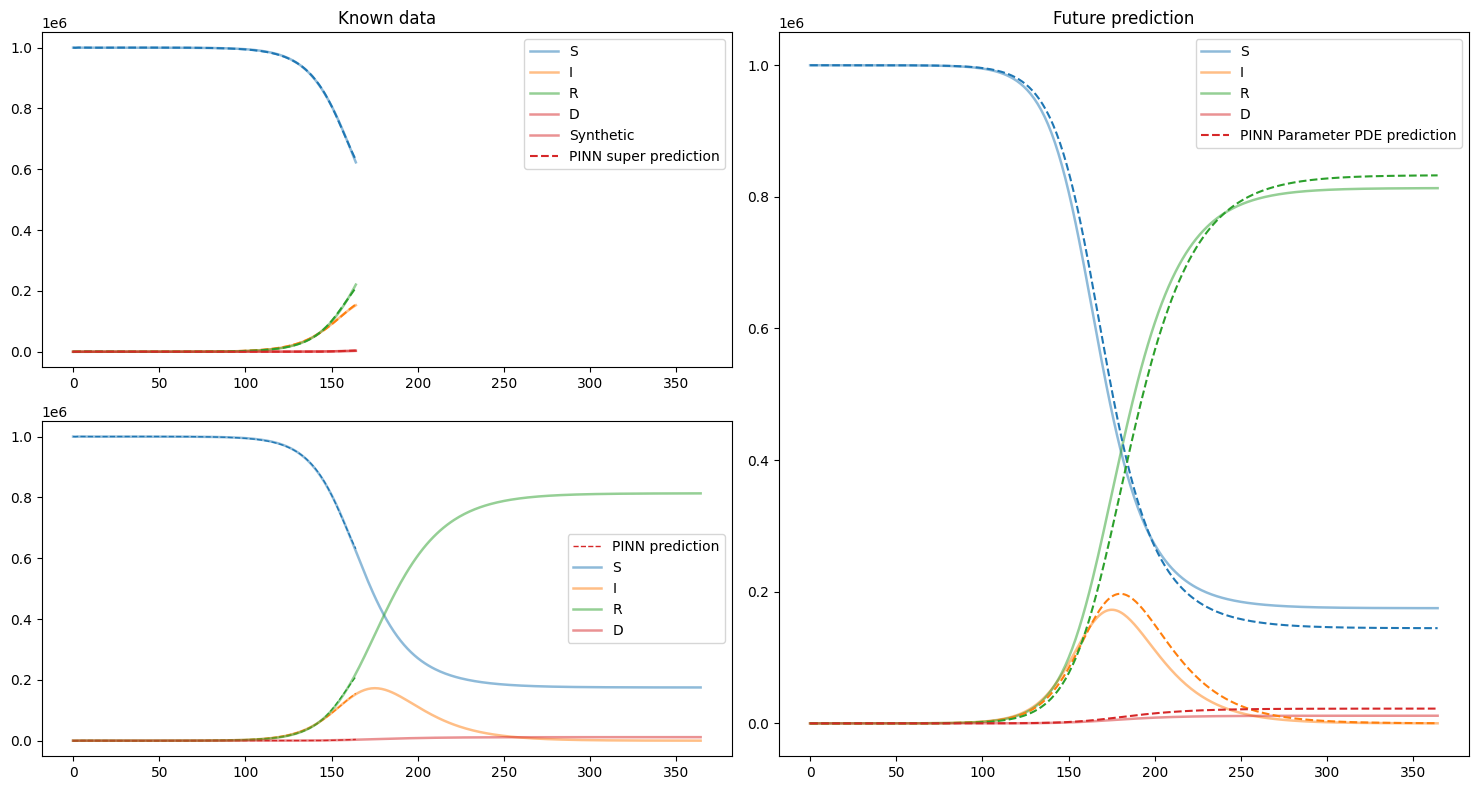

In [19]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
48000     [1.41e-06, 1.69e-07, 9.11e-07, 2.46e-08, 6.43e-06, 1.47e-05, 1.79e-06, 3.83e-06, 1.68e-06, 3.31e-05]    [1.41e-06, 1.69e-07, 9.11e-07, 2.46e-08, 6.43e-06, 1.47e-05, 1.79e-06, 3.83e-06, 1.68e-06, 3.31e-05]    []  
50000     [2.33e-06, 3.62e-07, 1.06e-06, 2.82e-08, 6.57e-06, 8.19e-06, 5.28e-06, 5.04e-06, 5.89e-06, 8.93e-05]    [2.33e-06, 3.62e-07, 1.06e-06, 2.82e-08, 6.57e-06, 8.19e-06, 5.28e-06, 5.04e-06, 5.89e-06, 8.93e-05]    []  

Best model at step 47522:
  train loss: 1.80e-06
  test loss: 1.80e-06
  test metric: []

'train' took 11.334642 s

Best train step: 47522
alpha: 0.1394687742
beta: 0.060069516301
gamma: 0.0016179349041
Training model...

Step      Train loss                                                              

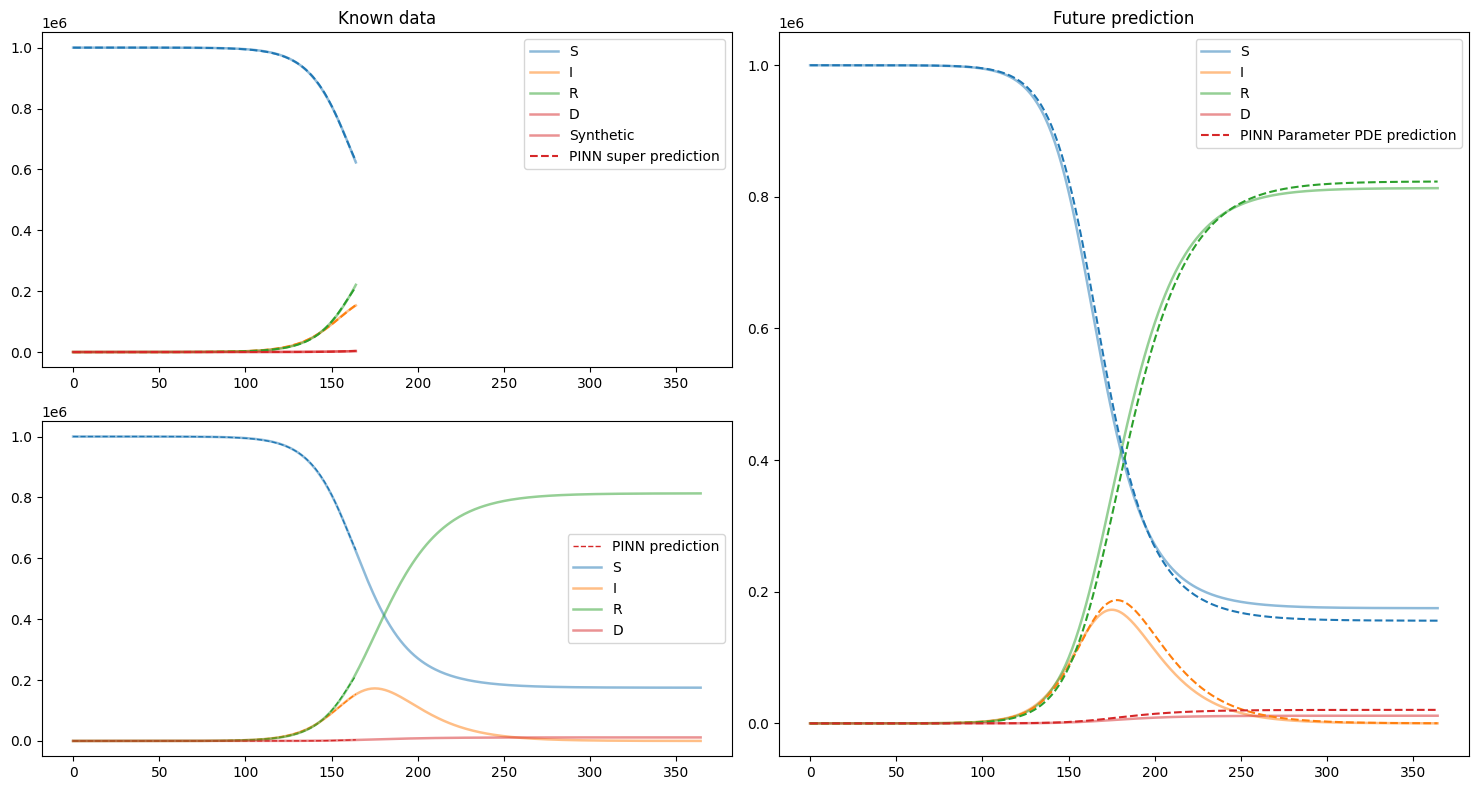

In [20]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
52000     [8.94e-07, 2.24e-08, 6.89e-07, 3.99e-09, 7.83e-08, 4.96e-07, 4.91e-08, 5.50e-07, 7.25e-08, 9.80e-07]    [8.94e-07, 2.24e-08, 6.89e-07, 3.99e-09, 7.83e-08, 4.96e-07, 4.91e-08, 5.50e-07, 7.25e-08, 9.80e-07]    []  
54000     [1.08e-05, 6.51e-07, 5.78e-06, 4.06e-07, 4.93e-06, 4.52e-05, 1.08e-06, 4.38e-06, 9.29e-07, 2.33e-05]    [1.08e-05, 6.51e-07, 5.78e-06, 4.06e-07, 4.93e-06, 4.52e-05, 1.08e-06, 4.38e-06, 9.29e-07, 2.33e-05]    []  

Best model at step 50884:
  train loss: 7.90e-07
  test loss: 7.90e-07
  test metric: []

'train' took 11.182053 s

Best train step: 50884
alpha: 0.14345934987
beta: 0.06357960403
gamma: 0.0015841558343
Training model...

Step      Train loss                                                              

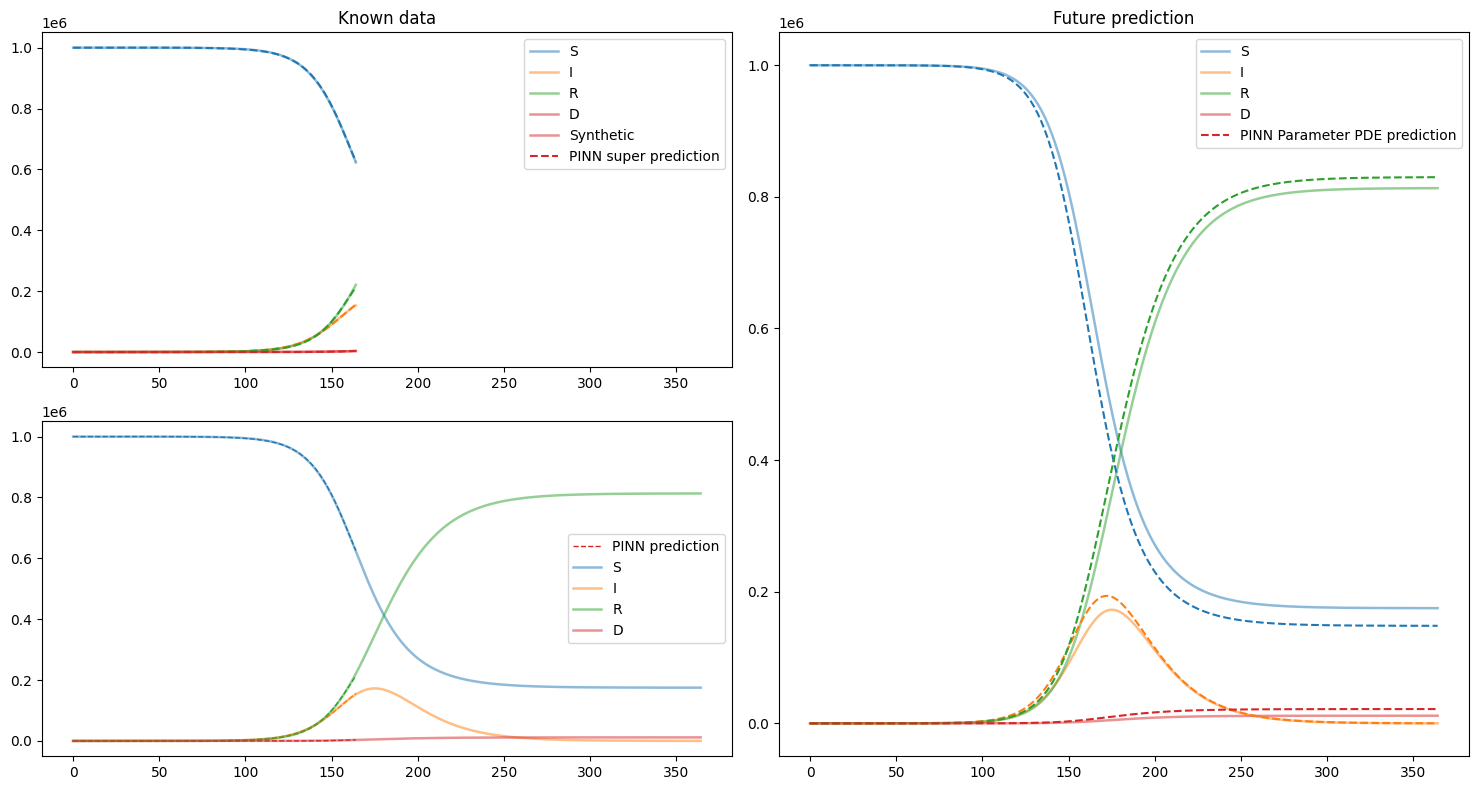

In [21]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
148000    [4.39e-06, 5.80e-07, 1.09e-06, 2.15e-07, 3.53e-06, 5.49e-06, 3.37e-06, 4.76e-06, 4.16e-06, 6.34e-05]    [4.39e-06, 5.80e-07, 1.09e-06, 2.15e-07, 3.53e-06, 5.49e-06, 3.37e-06, 4.76e-06, 4.16e-06, 6.34e-05]    []  
150000    [2.77e-08, 4.47e-08, 8.51e-08, 2.07e-10, 4.49e-10, 4.32e-08, 5.58e-08, 4.65e-08, 4.97e-09, 7.37e-08]    [2.77e-08, 4.47e-08, 8.51e-08, 2.07e-10, 4.49e-10, 4.32e-08, 5.58e-08, 4.65e-08, 4.97e-09, 7.37e-08]    []  

Best model at step 149991:
  train loss: 2.65e-07
  test loss: 2.65e-07
  test metric: []

'train' took 11.327333 s

Best train step: 149991
alpha: 0.14820870757
beta: 0.067068837583
gamma: 0.001304948004
Best train step: 149991
alpha: 0.14820870757
beta: 0.067068837583
gamma: 0.001304948004
{'alpha': 0

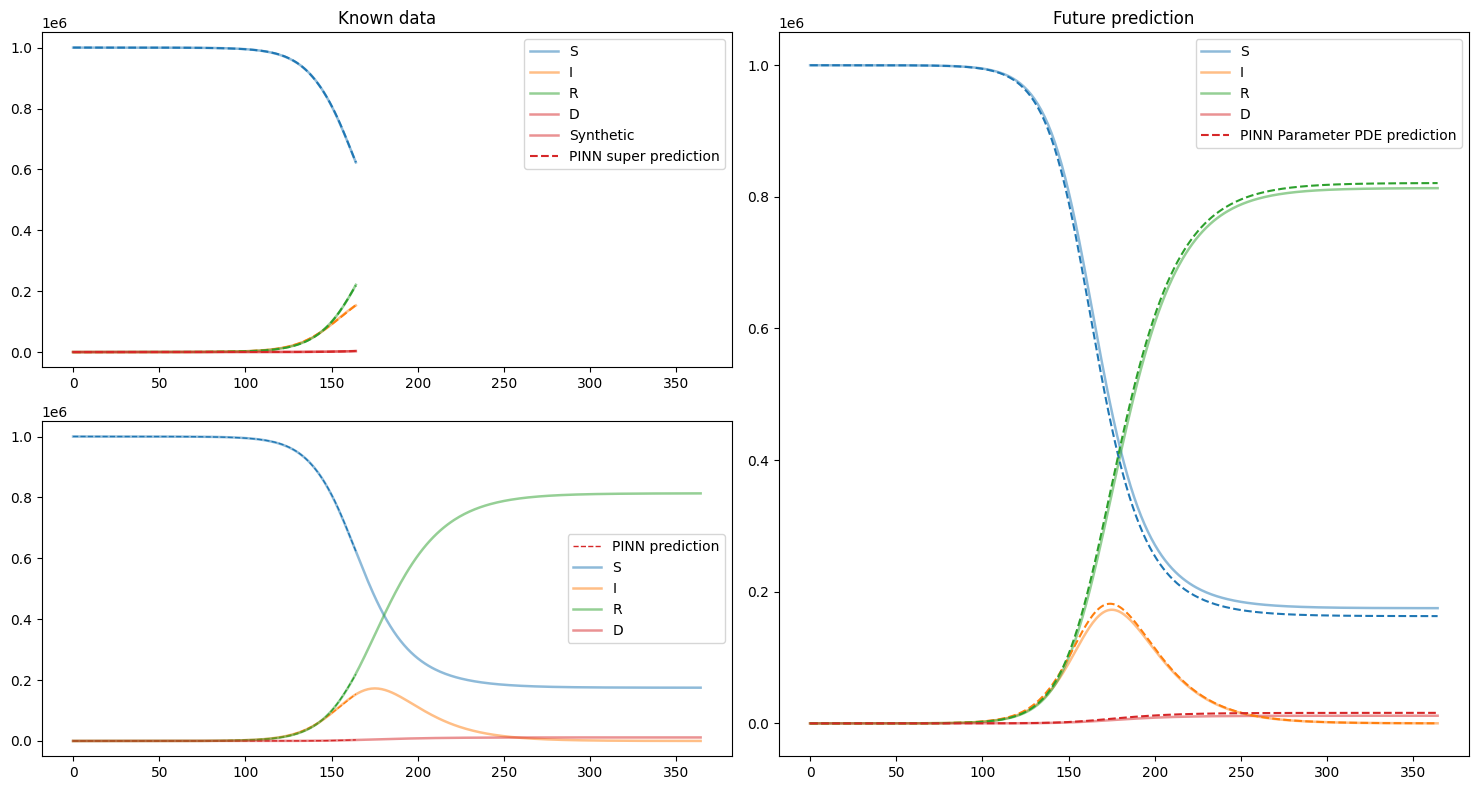

In [22]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
150000    [2.77e-08, 4.47e-08, 8.51e-08, 2.07e-10, 4.49e-10, 4.32e-08, 5.58e-08, 4.65e-08, 4.97e-09, 7.37e-08]    [2.77e-08, 4.47e-08, 8.51e-08, 2.07e-10, 4.49e-10, 4.32e-08, 5.58e-08, 4.65e-08, 4.97e-09, 7.37e-08]    []  
152000    [9.21e-06, 2.47e-06, 2.40e-06, 1.35e-08, 4.51e-05, 5.05e-05, 4.26e-05, 4.14e-05, 4.46e-05, 7.09e-04]    [9.21e-06, 2.47e-06, 2.40e-06, 1.35e-08, 4.51e-05, 5.05e-05, 4.26e-05, 4.14e-05, 4.46e-05, 7.09e-04]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 12.301429 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
{'alpha':

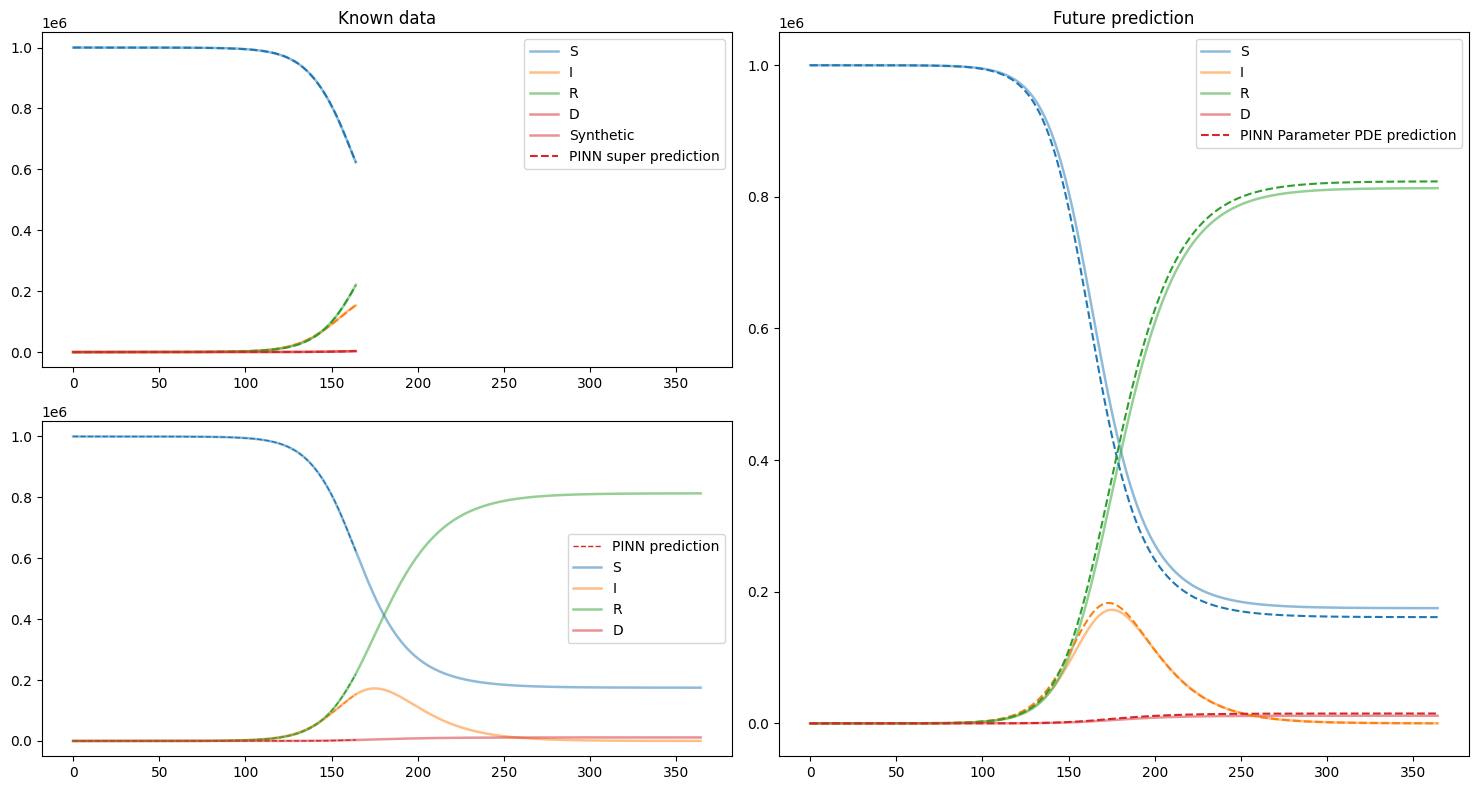

In [23]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
152000    [9.21e-06, 2.47e-06, 2.40e-06, 1.35e-08, 4.51e-05, 5.05e-05, 4.26e-05, 4.14e-05, 4.46e-05, 7.09e-04]    [9.21e-06, 2.47e-06, 2.40e-06, 1.35e-08, 4.51e-05, 5.05e-05, 4.26e-05, 4.14e-05, 4.46e-05, 7.09e-04]    []  
154000    [2.54e-06, 7.23e-07, 8.71e-07, 1.59e-09, 1.50e-05, 1.19e-05, 1.59e-05, 1.49e-05, 1.41e-05, 2.21e-04]    [2.54e-06, 7.23e-07, 8.71e-07, 1.59e-09, 1.50e-05, 1.19e-05, 1.59e-05, 1.49e-05, 1.41e-05, 2.21e-04]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 11.325419 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

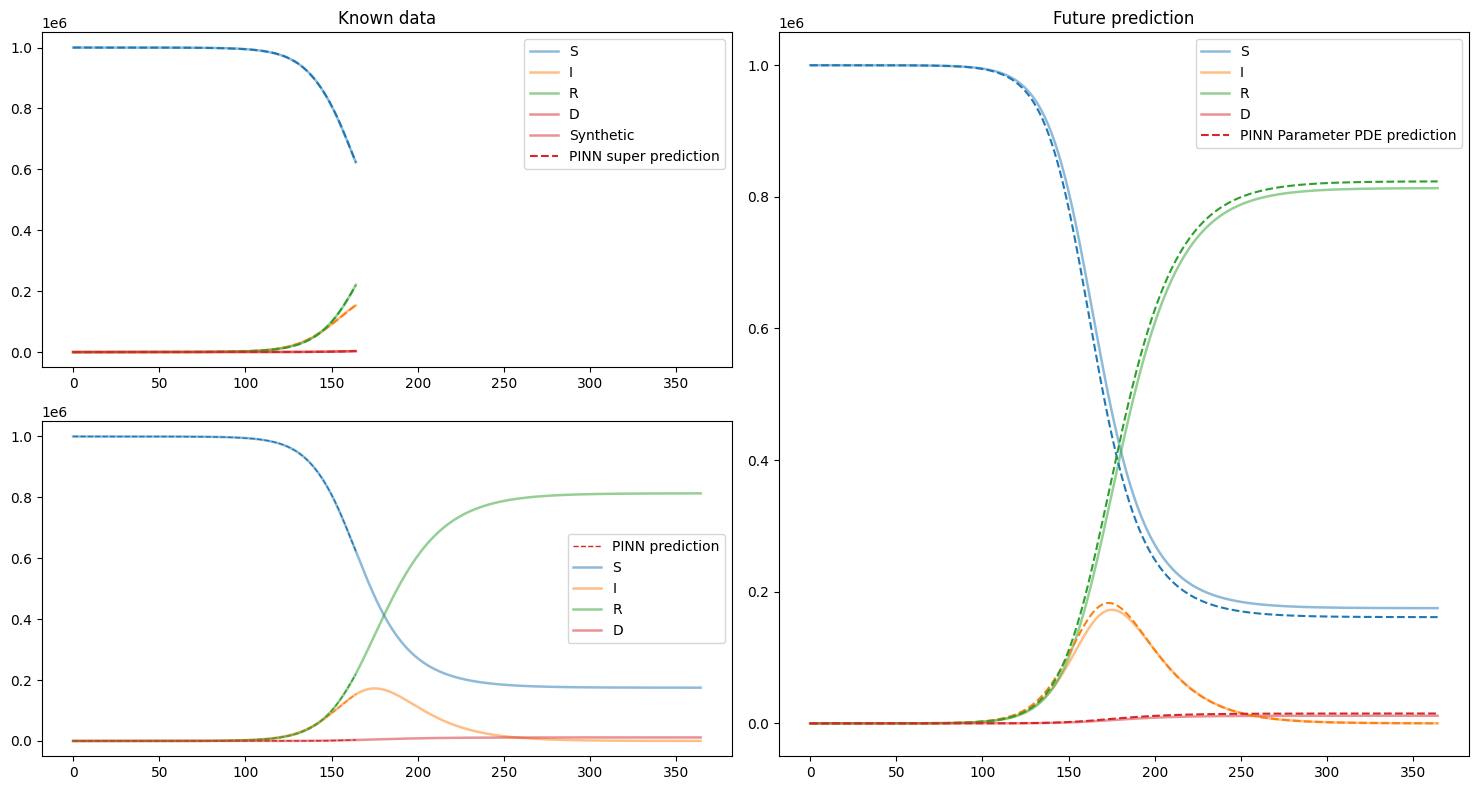

In [24]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
252000    [1.69e-06, 7.11e-08, 1.20e-06, 2.00e-09, 1.59e-07, 1.33e-06, 1.39e-06, 2.03e-06, 4.81e-08, 9.25e-07]    [1.69e-06, 7.11e-08, 1.20e-06, 2.00e-09, 1.59e-07, 1.33e-06, 1.39e-06, 2.03e-06, 4.81e-08, 9.25e-07]    []  
254000    [2.11e-06, 9.06e-08, 1.41e-06, 2.23e-09, 2.15e-12, 8.63e-07, 1.41e-06, 1.94e-06, 6.12e-10, 7.12e-11]    [2.11e-06, 9.06e-08, 1.41e-06, 2.23e-09, 2.15e-12, 8.63e-07, 1.41e-06, 1.94e-06, 6.12e-10, 7.12e-11]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 11.774470 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

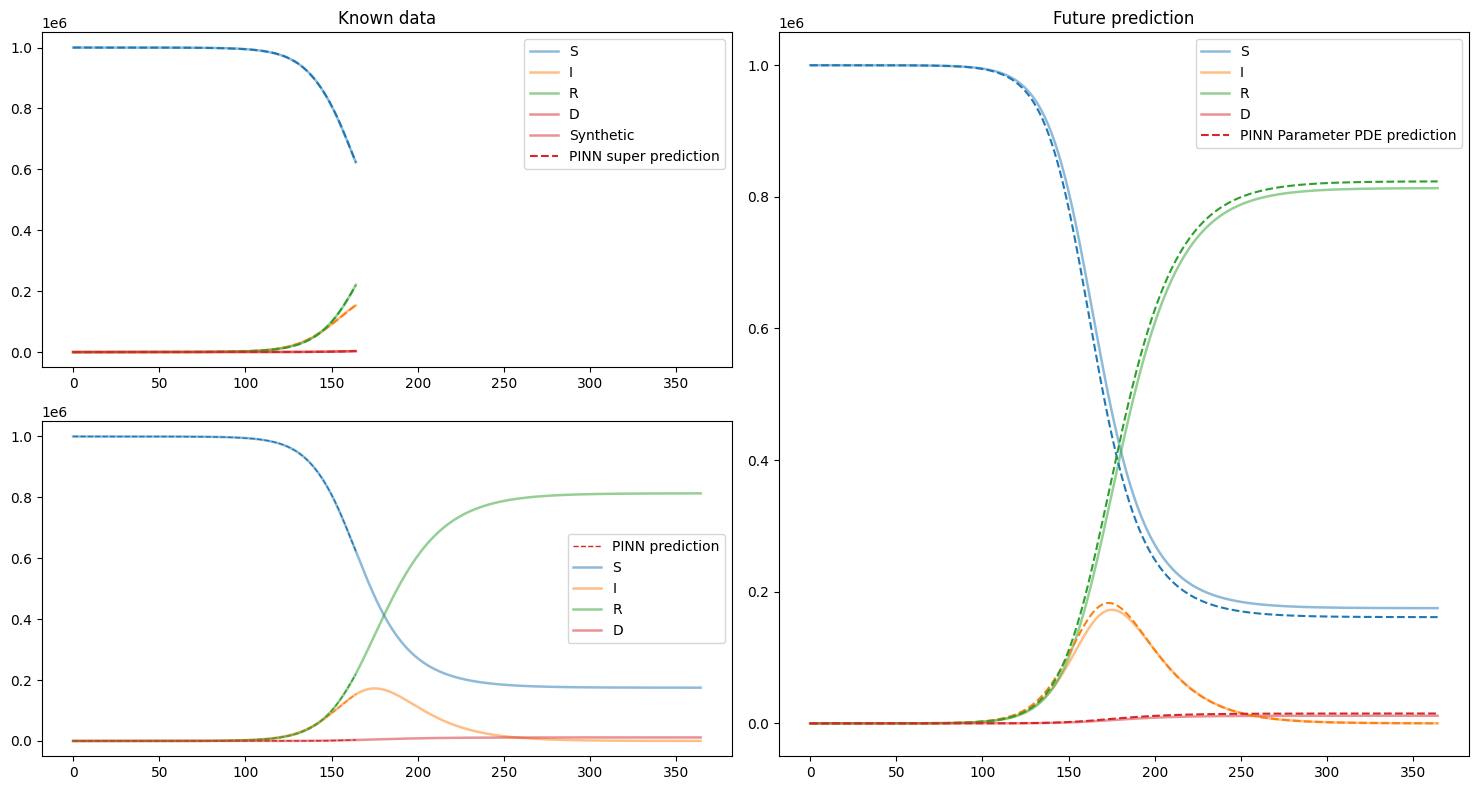

In [25]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
352000    [7.91e-06, 7.55e-07, 1.92e-06, 7.13e-07, 5.14e-07, 8.98e-06, 1.31e-05, 1.85e-05, 5.02e-06, 6.53e-05]    [7.91e-06, 7.55e-07, 1.92e-06, 7.13e-07, 5.14e-07, 8.98e-06, 1.31e-05, 1.85e-05, 5.02e-06, 6.53e-05]    []  
354000    [1.65e-06, 8.45e-08, 1.19e-06, 8.65e-10, 5.02e-08, 1.27e-06, 1.07e-06, 1.86e-06, 1.86e-08, 2.97e-08]    [1.65e-06, 8.45e-08, 1.19e-06, 8.65e-10, 5.02e-08, 1.27e-06, 1.07e-06, 1.86e-06, 1.86e-08, 2.97e-08]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 10.225210 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

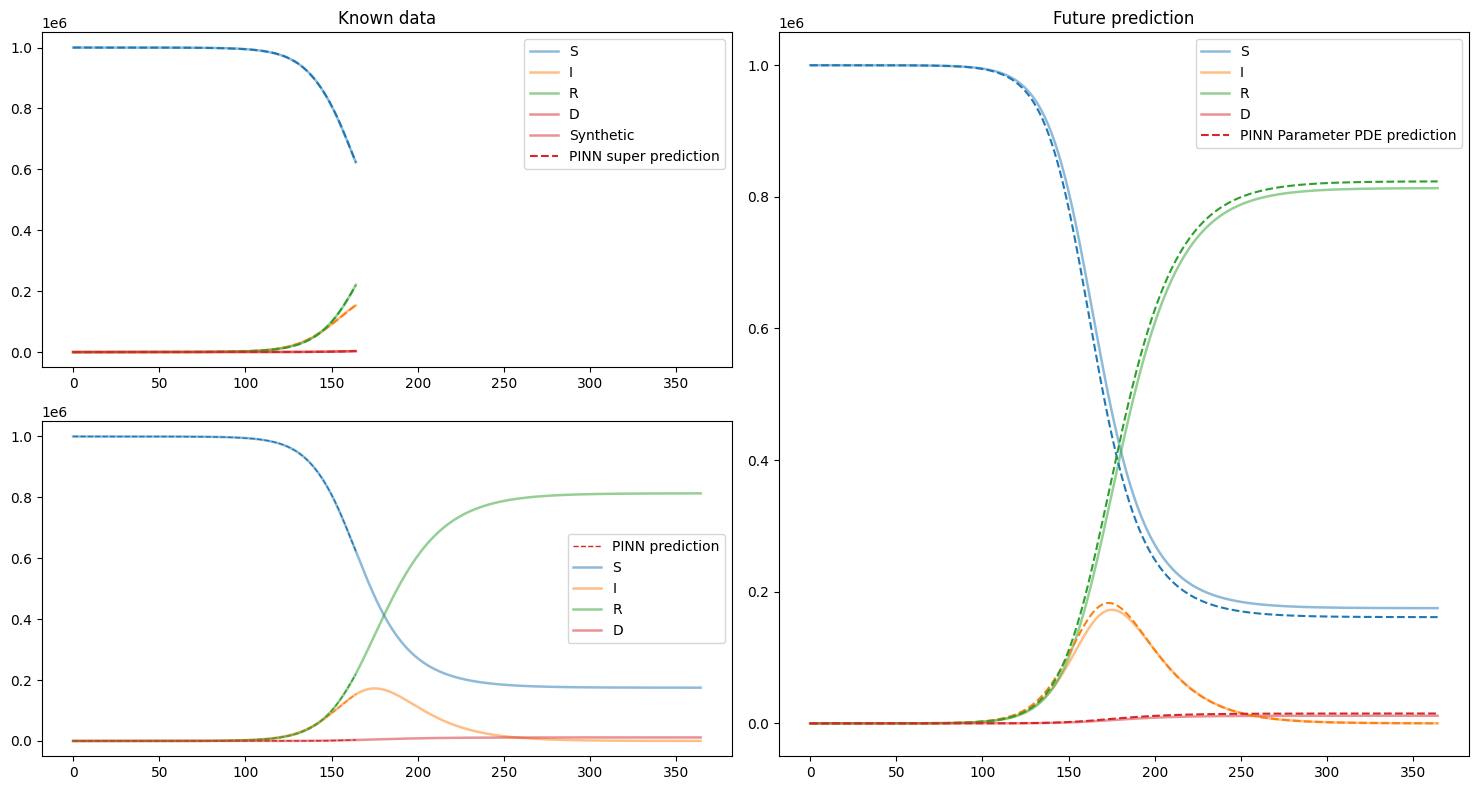

In [26]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
452000    [1.73e-06, 4.07e-08, 1.23e-06, 2.12e-09, 4.19e-09, 1.91e-06, 1.17e-07, 1.88e-06, 2.12e-08, 3.22e-08]    [1.73e-06, 4.07e-08, 1.23e-06, 2.12e-09, 4.19e-09, 1.91e-06, 1.17e-07, 1.88e-06, 2.12e-08, 3.22e-08]    []  
454000    [2.38e-06, 1.08e-07, 1.45e-06, 9.49e-09, 1.83e-08, 4.96e-06, 4.96e-07, 3.30e-06, 9.11e-08, 1.58e-07]    [2.38e-06, 1.08e-07, 1.45e-06, 9.49e-09, 1.83e-08, 4.96e-06, 4.96e-07, 3.30e-06, 9.11e-08, 1.58e-07]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 10.208881 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

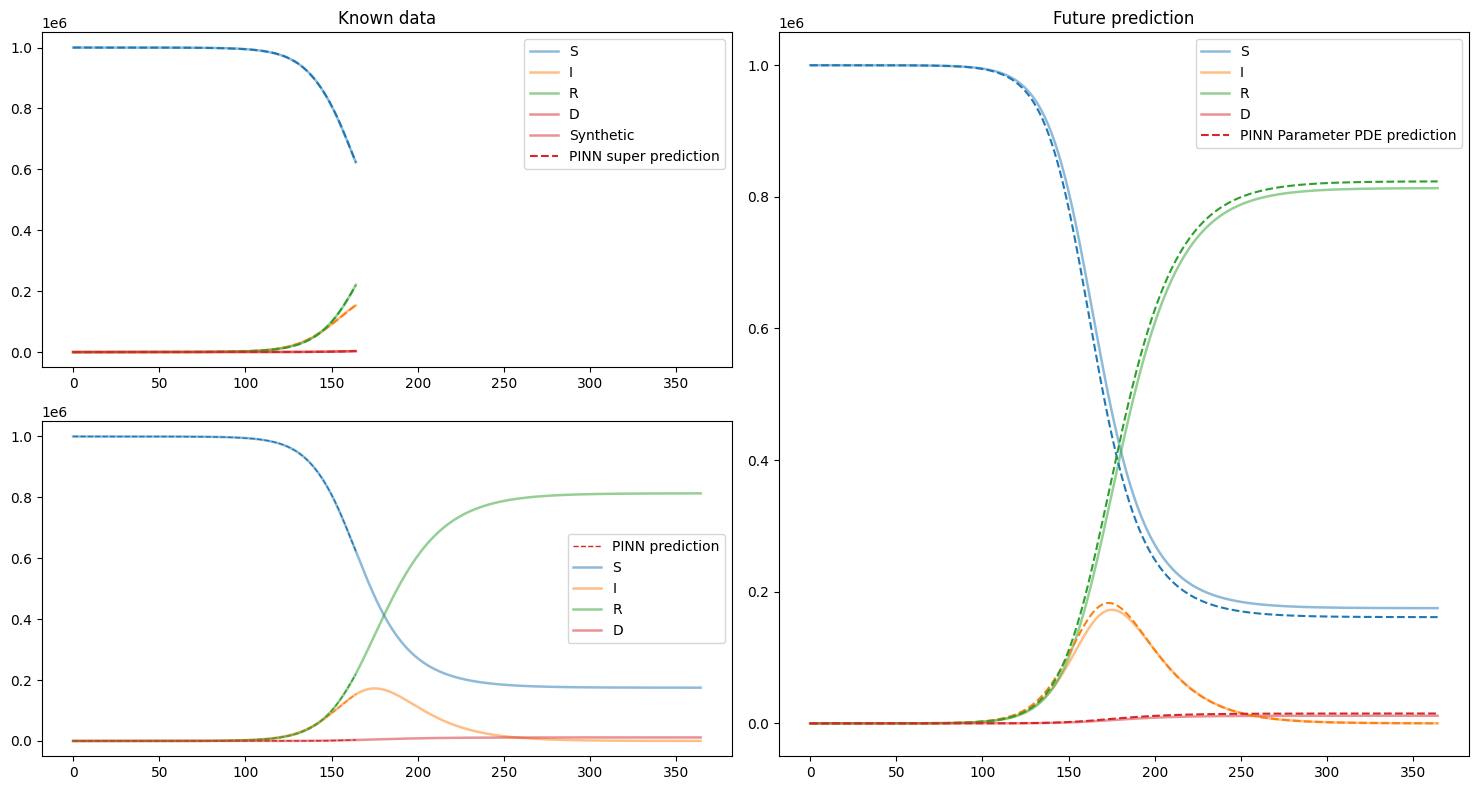

In [27]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
552000    [4.55e-06, 3.99e-07, 1.57e-06, 7.03e-07, 2.92e-05, 4.49e-05, 4.48e-06, 6.44e-06, 1.02e-05, 1.70e-04]    [4.55e-06, 3.99e-07, 1.57e-06, 7.03e-07, 2.92e-05, 4.49e-05, 4.48e-06, 6.44e-06, 1.02e-05, 1.70e-04]    []  
554000    [2.08e-06, 1.35e-07, 1.37e-06, 8.03e-10, 5.74e-07, 1.61e-06, 1.88e-06, 1.75e-06, 2.85e-07, 4.76e-06]    [2.08e-06, 1.35e-07, 1.37e-06, 8.03e-10, 5.74e-07, 1.61e-06, 1.88e-06, 1.75e-06, 2.85e-07, 4.76e-06]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 11.941881 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

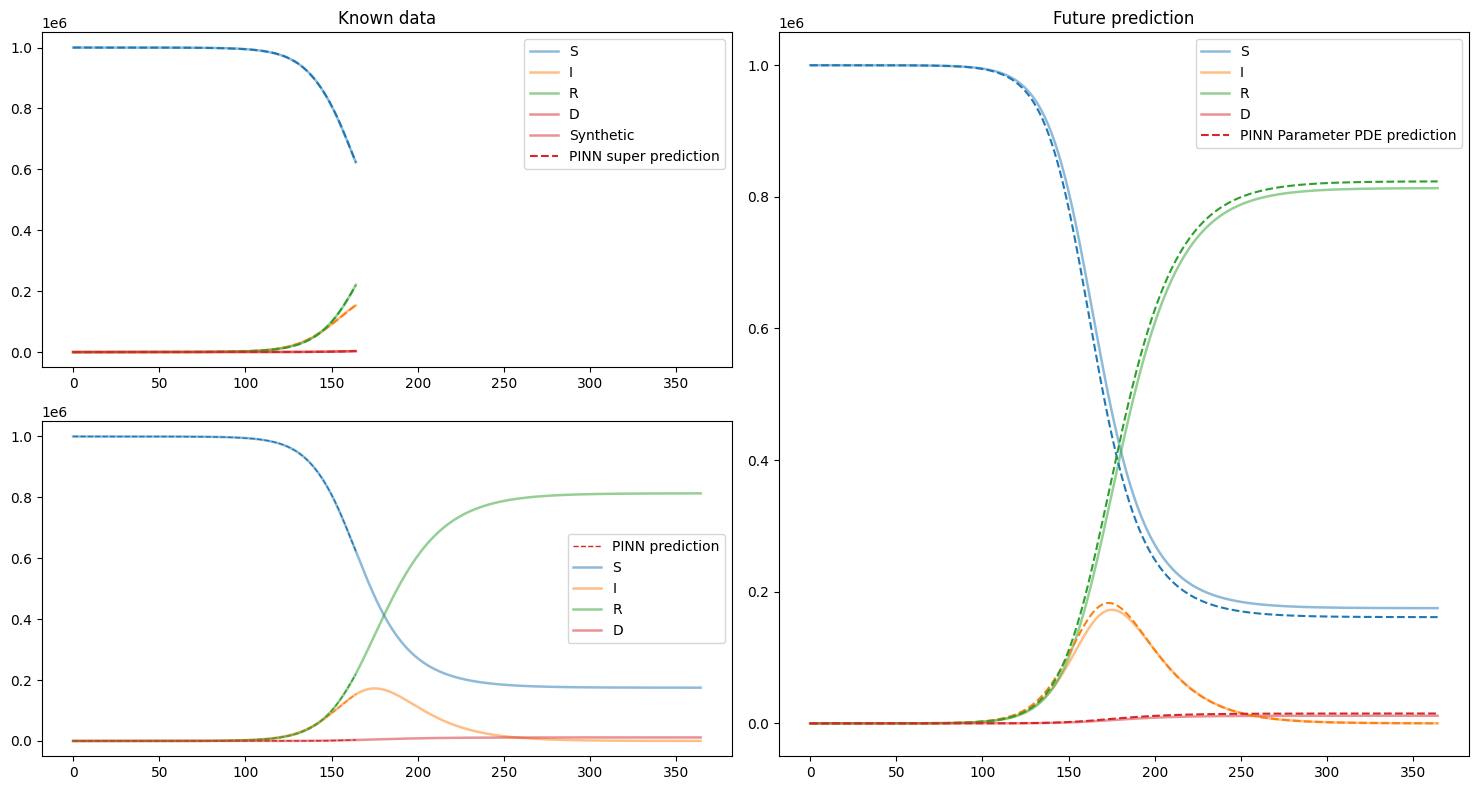

In [28]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
652000    [2.20e-05, 5.61e-06, 7.00e-06, 9.14e-09, 4.03e-05, 5.24e-05, 1.52e-04, 1.92e-04, 1.07e-04, 1.62e-03]    [2.20e-05, 5.61e-06, 7.00e-06, 9.14e-09, 4.03e-05, 5.24e-05, 1.52e-04, 1.92e-04, 1.07e-04, 1.62e-03]    []  
654000    [7.08e-06, 1.21e-06, 2.45e-06, 1.13e-07, 2.08e-05, 2.60e-05, 1.13e-05, 1.41e-05, 1.55e-05, 2.45e-04]    [7.08e-06, 1.21e-06, 2.45e-06, 1.13e-07, 2.08e-05, 2.60e-05, 1.13e-05, 1.41e-05, 1.55e-05, 2.45e-04]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 12.593674 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

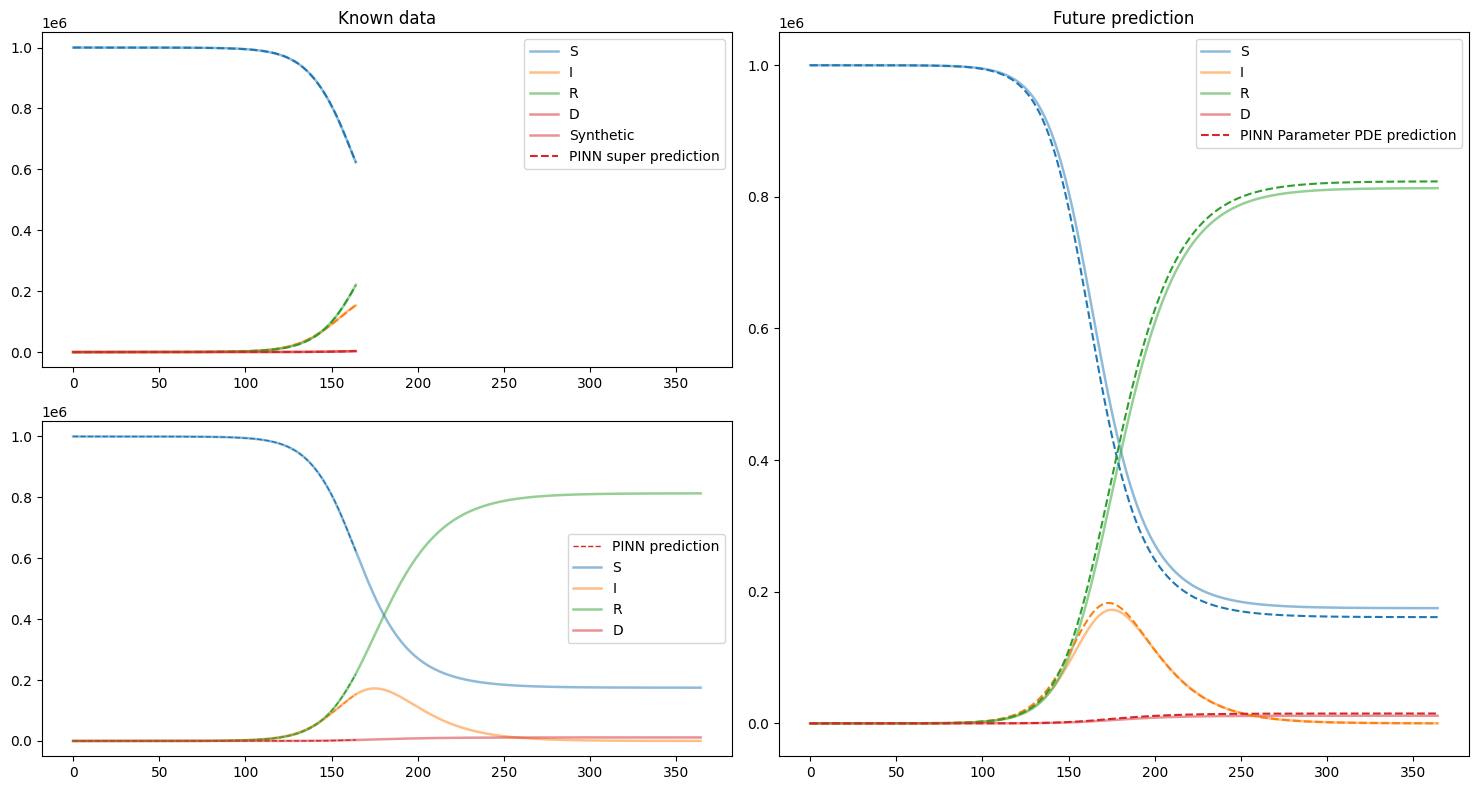

In [29]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
752000    [1.43e-06, 8.56e-08, 1.25e-06, 5.08e-08, 1.46e-07, 1.74e-06, 1.11e-06, 3.26e-06, 1.11e-06, 4.55e-06]    [1.43e-06, 8.56e-08, 1.25e-06, 5.08e-08, 1.46e-07, 1.74e-06, 1.11e-06, 3.26e-06, 1.11e-06, 4.55e-06]    []  
754000    [1.01e-06, 6.32e-08, 9.30e-07, 1.67e-08, 5.04e-07, 1.00e-06, 5.67e-07, 1.29e-06, 6.30e-07, 3.07e-06]    [1.01e-06, 6.32e-08, 9.30e-07, 1.67e-08, 5.04e-07, 1.00e-06, 5.67e-07, 1.29e-06, 6.30e-07, 3.07e-06]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 12.539528 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

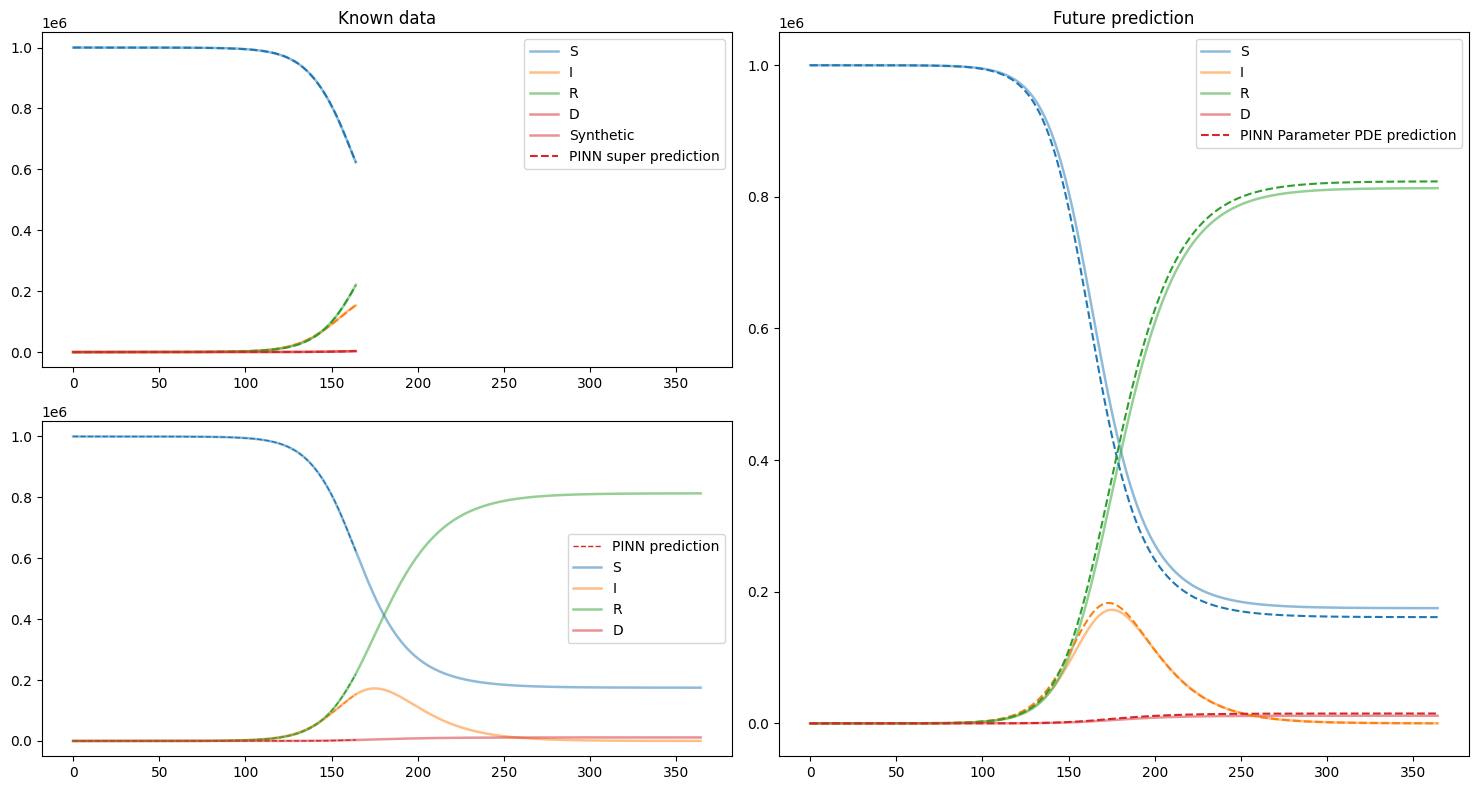

In [30]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
852000    [2.07e-06, 8.88e-08, 1.38e-06, 1.77e-09, 4.21e-09, 8.01e-07, 1.28e-06, 2.05e-06, 6.54e-10, 5.24e-09]    [2.07e-06, 8.88e-08, 1.38e-06, 1.77e-09, 4.21e-09, 8.01e-07, 1.28e-06, 2.05e-06, 6.54e-10, 5.24e-09]    []  
854000    [2.09e-06, 4.29e-07, 1.11e-06, 1.61e-09, 9.75e-06, 1.66e-05, 5.15e-06, 4.04e-06, 5.28e-06, 8.71e-05]    [2.09e-06, 4.29e-07, 1.11e-06, 1.61e-09, 9.75e-06, 1.66e-05, 5.15e-06, 4.04e-06, 5.28e-06, 8.71e-05]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 12.594332 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

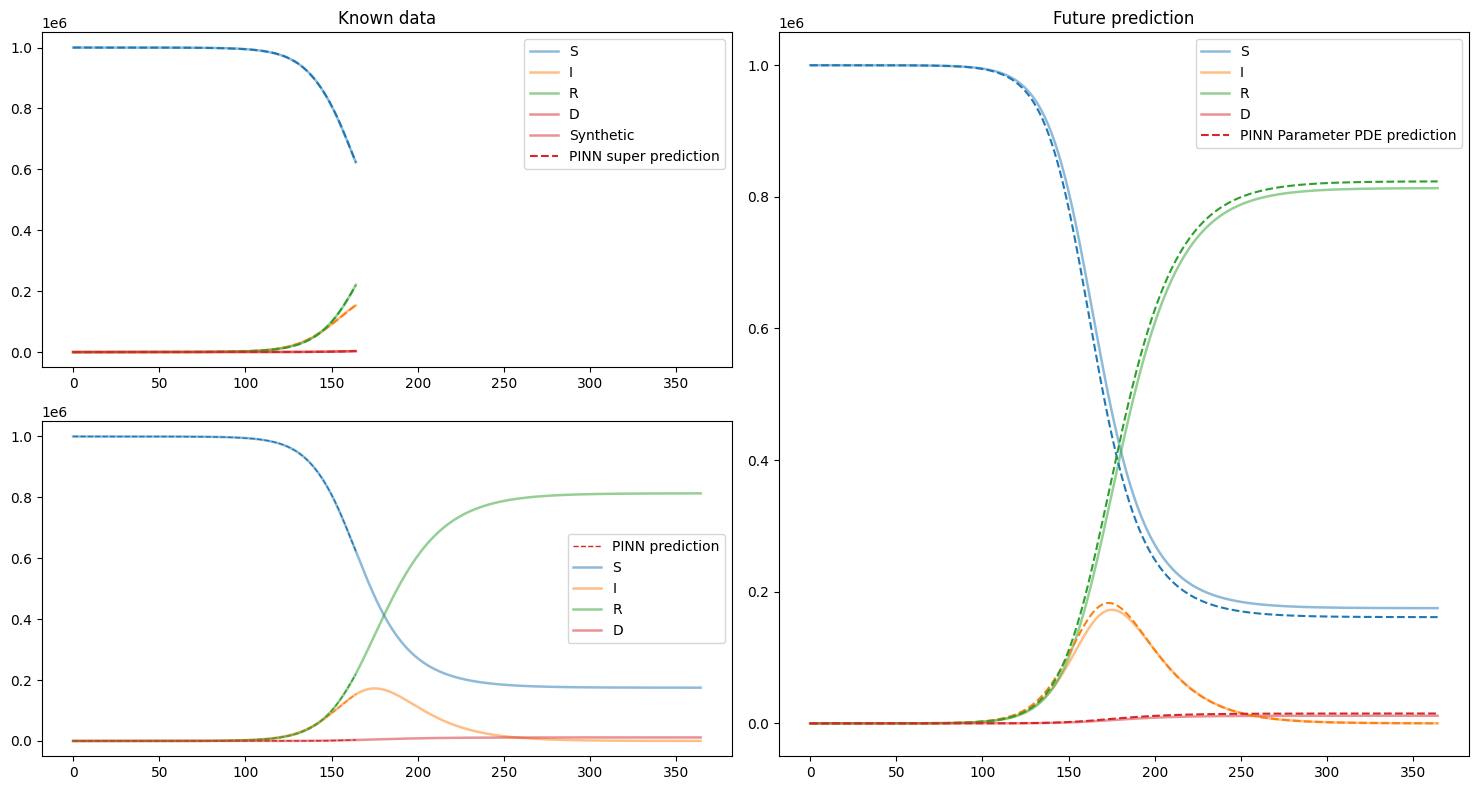

In [31]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
952000    [4.22e-07, 4.07e-08, 4.69e-07, 3.98e-10, 9.56e-07, 3.02e-06, 2.60e-07, 4.84e-07, 1.66e-07, 3.06e-06]    [4.22e-07, 4.07e-08, 4.69e-07, 3.98e-10, 9.56e-07, 3.02e-06, 2.60e-07, 4.84e-07, 1.66e-07, 3.06e-06]    []  
954000    [5.50e-07, 6.26e-08, 5.86e-07, 3.59e-10, 9.92e-08, 5.74e-07, 2.06e-07, 1.90e-07, 1.53e-08, 2.02e-07]    [5.50e-07, 6.26e-08, 5.86e-07, 3.59e-10, 9.92e-08, 5.74e-07, 2.06e-07, 1.90e-07, 1.53e-08, 2.02e-07]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 13.303086 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

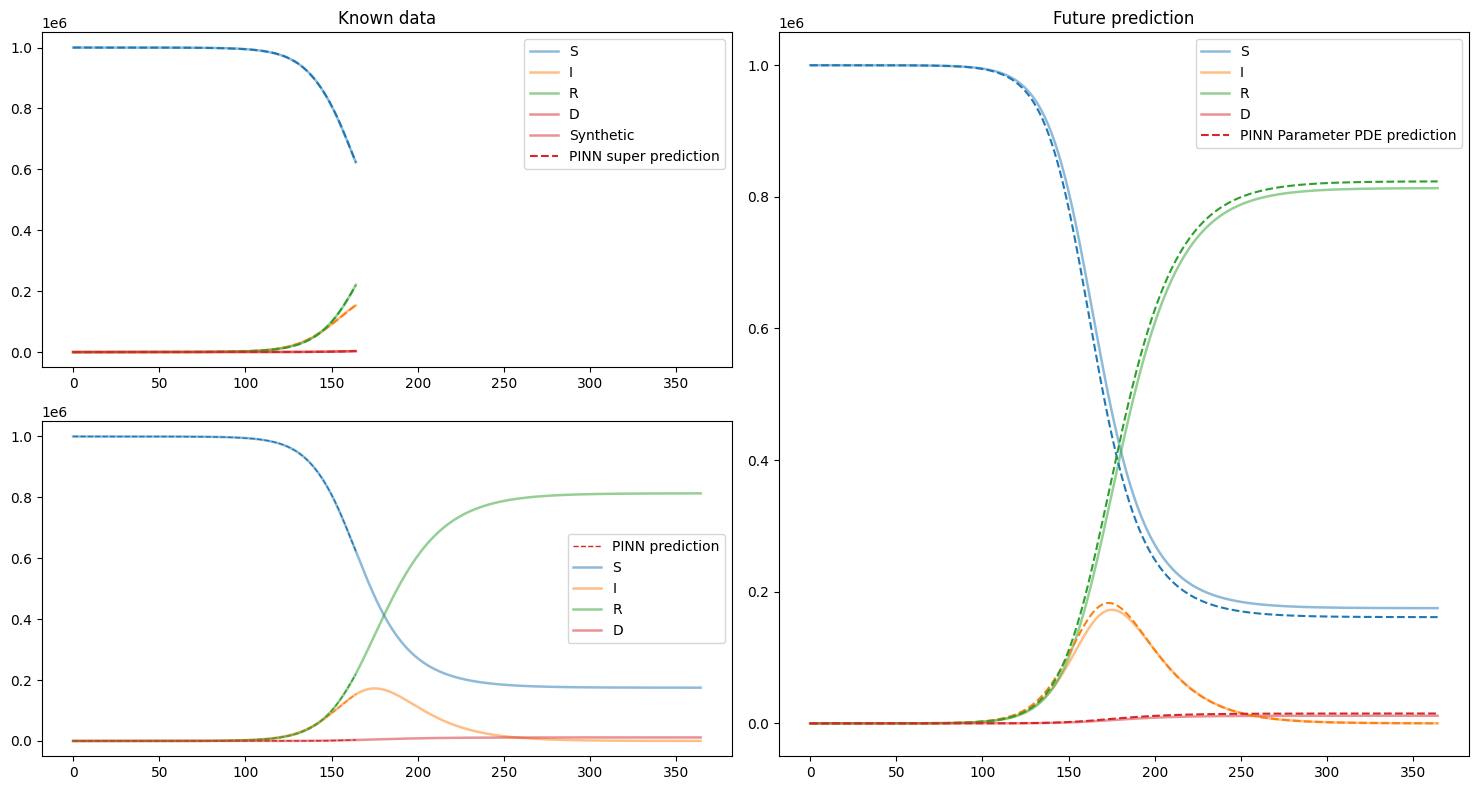

In [32]:
intermediate_train()

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
1052000   [1.55e-06, 6.96e-08, 1.13e-06, 1.40e-09, 9.02e-08, 1.90e-06, 1.34e-06, 2.28e-06, 6.95e-08, 1.14e-06]    [1.55e-06, 6.96e-08, 1.13e-06, 1.40e-09, 9.02e-08, 1.90e-06, 1.34e-06, 2.28e-06, 6.95e-08, 1.14e-06]    []  
1054000   [1.82e-06, 4.92e-08, 1.30e-06, 1.89e-09, 4.40e-07, 1.24e-06, 1.45e-06, 2.35e-06, 3.88e-07, 6.06e-06]    [1.82e-06, 4.92e-08, 1.30e-06, 1.89e-09, 4.40e-07, 1.24e-06, 1.45e-06, 2.35e-06, 3.88e-07, 6.06e-06]    []  

Best model at step 150023:
  train loss: 2.58e-07
  test loss: 2.58e-07
  test metric: []

'train' took 14.672827 s

Best train step: 150023
alpha: 0.14858686924
beta: 0.067098118365
gamma: 0.0012203630758
Training model...

Step      Train loss                                                           

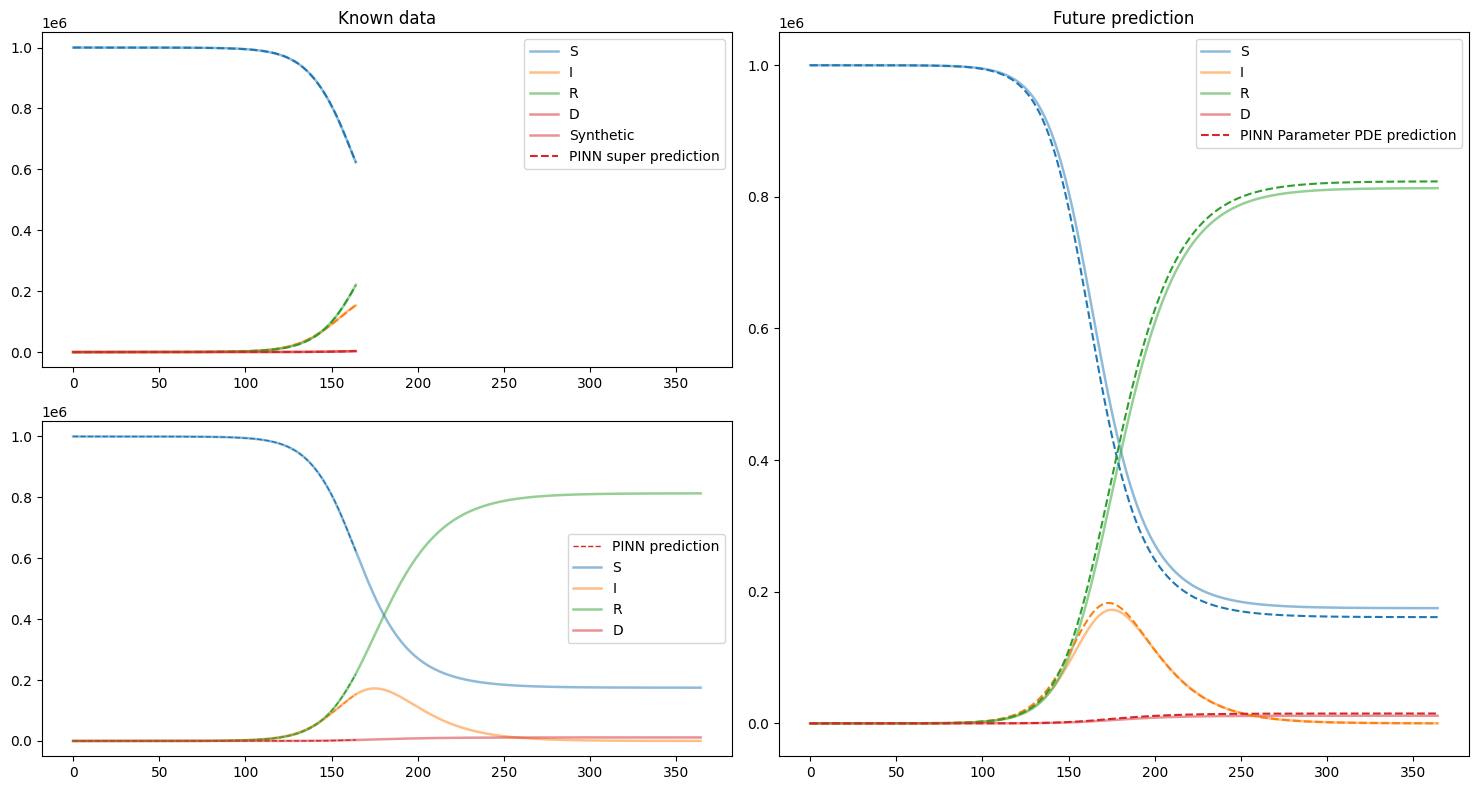

In [33]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
48000     [3.93e-06, 2.67e-07, 2.10e-06, 6.34e-09, 6.70e-11, 1.85e-06, 3.39e-07, 1.13e-06, 1.80e-08, 1.95e-08, 4.99e-10, 1.85e-10, 4.04e-11, 1.19e-11, 3.21e-11, 1.71e-12, 8.73e-10, 5.12e-06, 5.53e-07, 2.11e-06, 2.13e-09]    [3.93e-06, 2.67e-07, 2.10e-06, 6.34e-09, 6.70e-11, 1.85e-06, 3.39e-07, 1.13e-06, 1.80e-08, 1.95e-08, 4.99e-10, 1.85e-10, 4.04e-11, 1.19e-11, 3.21e-11, 1.71e-12, 8.73e-10, 5.12e-06, 5.53e-07, 2.11e-06, 2.13e-09]    []  
50000     [1.17e-05, 9.55e-07, 4.88e-06, 5.14e-07, 1.83e-05, 3.80e-05, 1.80e-05, 2.03e-0

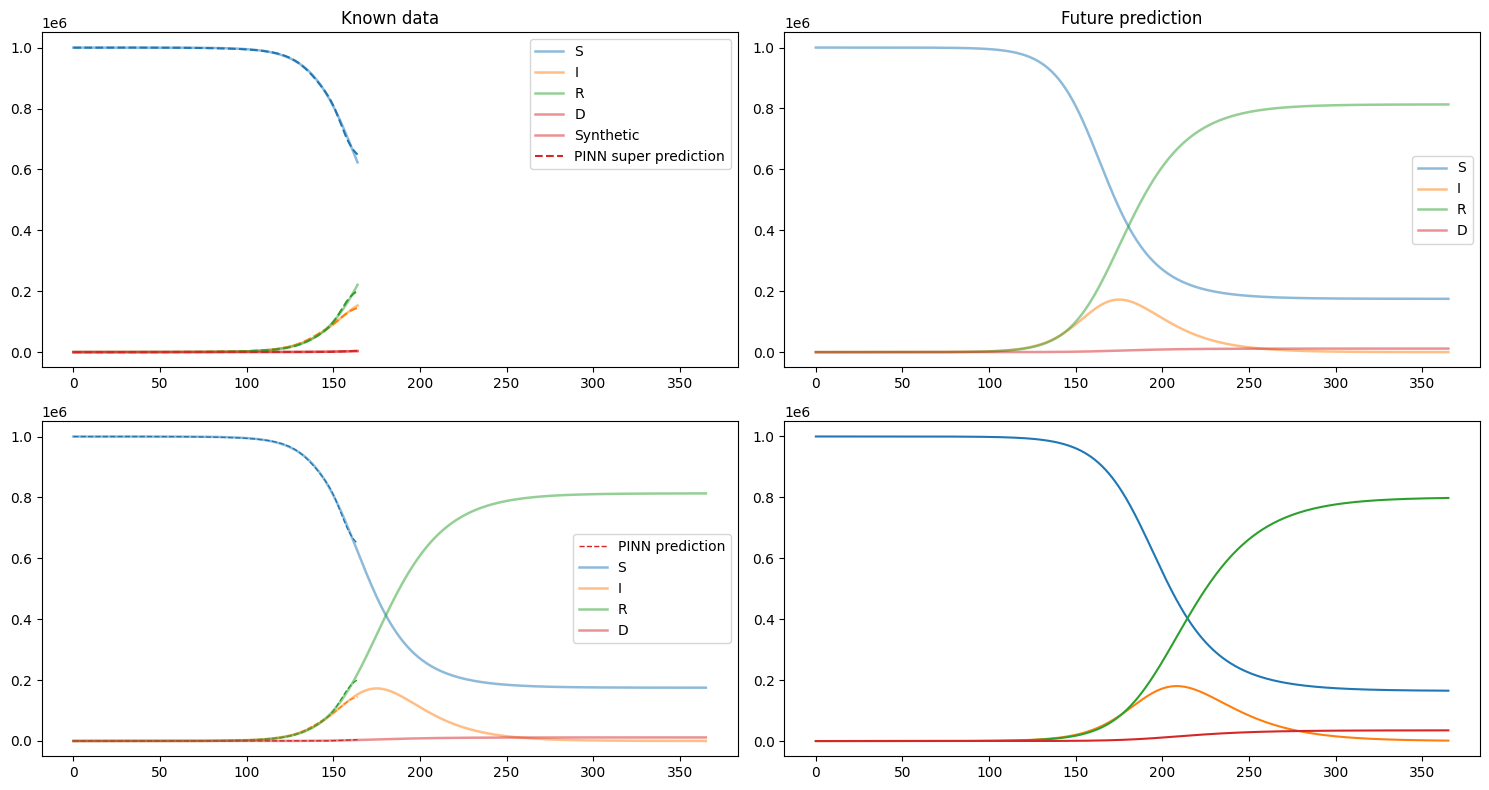

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
50000     [1.17e-05, 9.55e-07, 4.88e-06, 5.14e-07, 1.83e-05, 3.80e-05, 1.80e-05, 2.03e-05, 2.44e-05, 3.28e-04, 0.00e+00, 0.00e+00, 0.00e+00, 5.97e-08, 4.64e-10, 6.10e-08, 4.87e-10, 8.96e-07, 9.35e-08, 3.96e-07, 4.49e-10]    [1.17e-05, 9.55e-07, 4.88e-06, 5.14e-07, 1.83e-05, 3.80e-05, 1.80e-05, 2.03e-05, 2.44e-05, 3.28e-04, 0.00e+00, 0.00e+00, 0.00e+00, 5.97e-08, 4.64e-10, 6.10e-08, 4.87e-10, 8.96e-07, 9.35e-08, 3.96e-07, 4.49e-10]    []  
52000     [6.85e-06, 7.87e-07, 2.98e-06, 3.82e-09, 2.29e-07, 1.05e-05, 1.63e-06, 6.21e-0

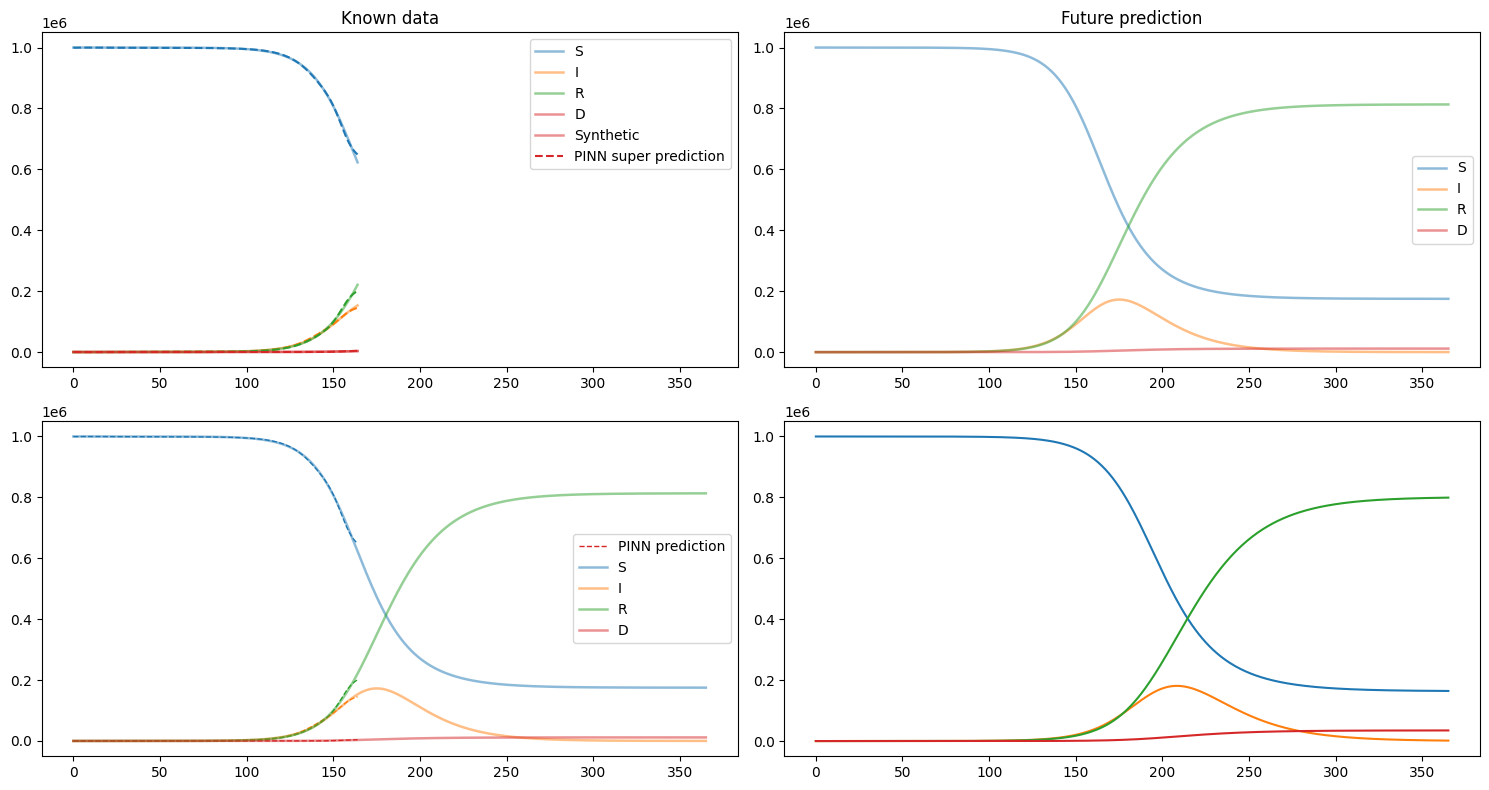

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
52000     [6.85e-06, 7.87e-07, 2.98e-06, 3.82e-09, 2.29e-07, 1.05e-05, 1.63e-06, 6.21e-06, 1.50e-08, 4.63e-07, 5.24e-11, 0.00e+00, 4.51e-10, 1.46e-09, 2.45e-09, 8.55e-10, 4.31e-10, 3.05e-06, 6.07e-07, 1.01e-06, 8.27e-10]    [6.85e-06, 7.87e-07, 2.98e-06, 3.82e-09, 2.29e-07, 1.05e-05, 1.63e-06, 6.21e-06, 1.50e-08, 4.63e-07, 5.24e-11, 0.00e+00, 4.51e-10, 1.46e-09, 2.45e-09, 8.55e-10, 4.31e-10, 3.05e-06, 6.07e-07, 1.01e-06, 8.27e-10]    []  
54000     [3.67e-06, 2.50e-07, 1.95e-06, 6.63e-09, 1.19e-10, 3.51e-06, 2.72e-07, 2.21e-0

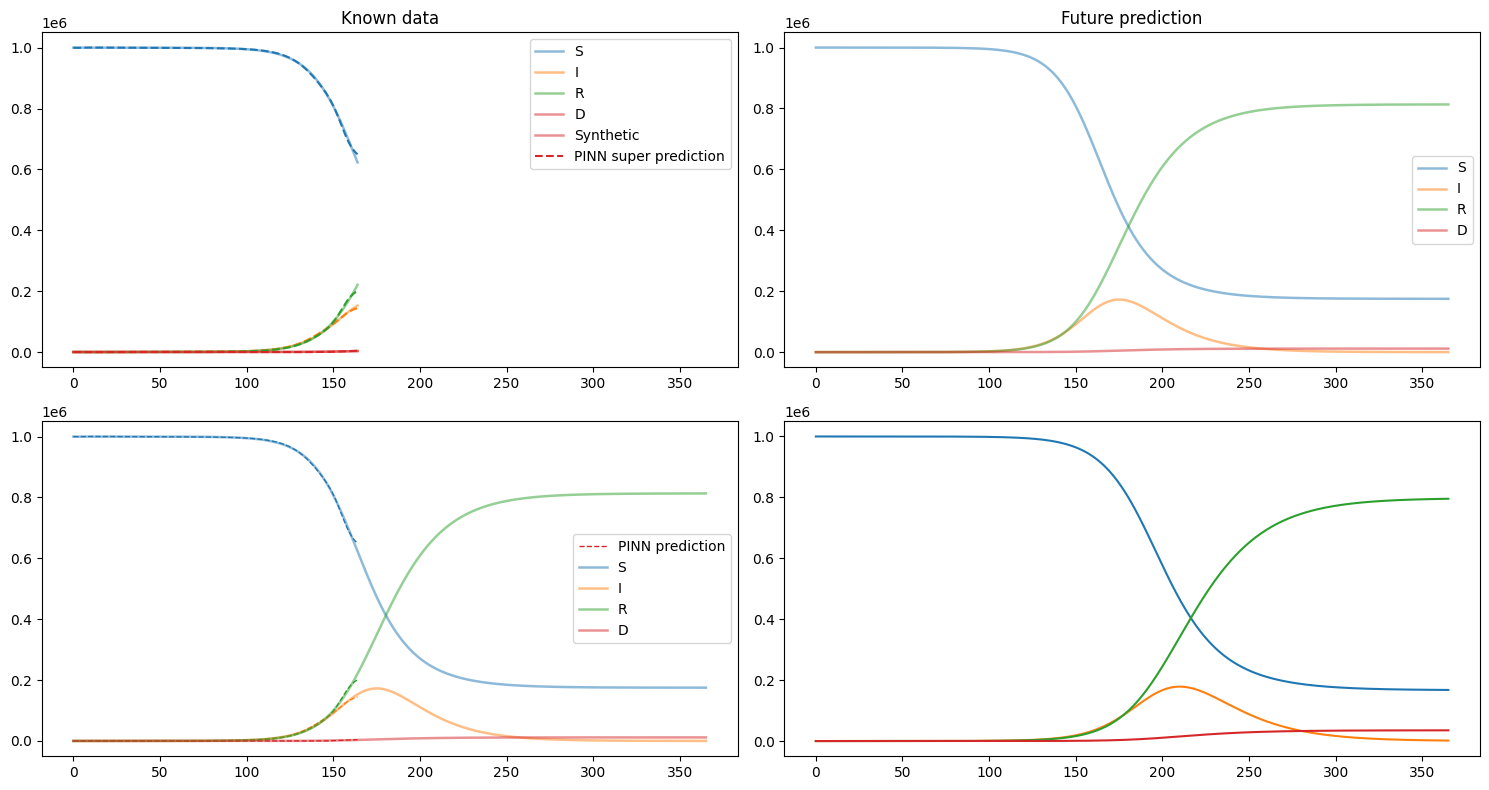

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
104000    [4.02e-06, 2.84e-07, 2.14e-06, 6.38e-09, 1.08e-10, 1.86e-06, 3.79e-07, 1.05e-06, 1.96e-08, 1.99e-08, 3.88e-10, 2.40e-10, 6.75e-11, 7.80e-12, 3.41e-11, 5.27e-12, 2.60e-10, 4.82e-06, 4.92e-07, 2.02e-06, 2.33e-09]    [4.02e-06, 2.84e-07, 2.14e-06, 6.38e-09, 1.08e-10, 1.86e-06, 3.79e-07, 1.05e-06, 1.96e-08, 1.99e-08, 3.88e-10, 2.40e-10, 6.75e-11, 7.80e-12, 3.41e-11, 5.27e-12, 2.60e-10, 4.82e-06, 4.92e-07, 2.02e-06, 2.33e-09]    []  
106000    [2.99e-05, 7.33e-06, 6.14e-06, 7.52e-07, 9.32e-05, 1.68e-04, 5.93e-05, 7.47e-0

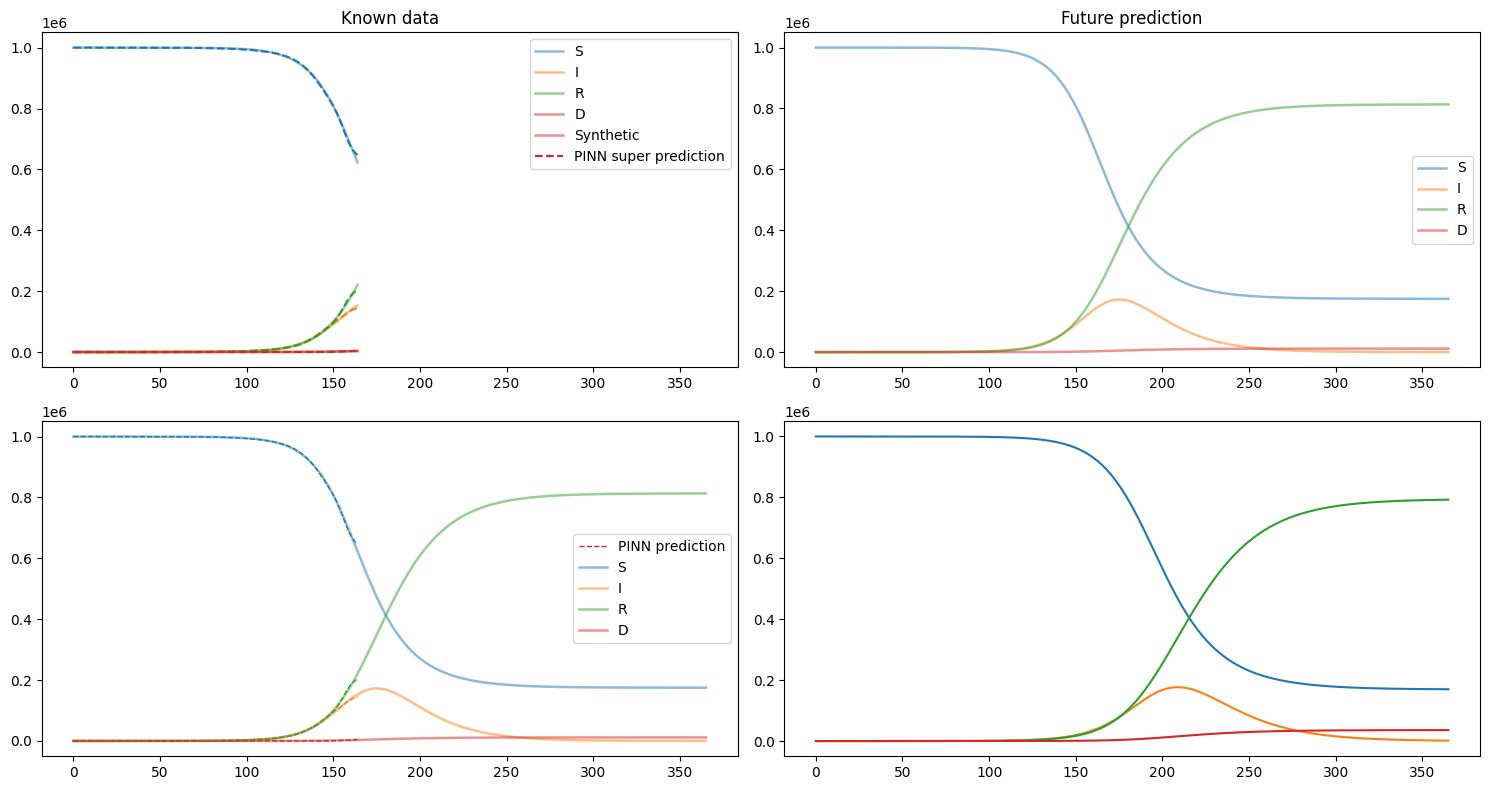

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
194000    [4.04e-06, 3.05e-07, 2.17e-06, 7.23e-09, 3.38e-12, 1.47e-06, 3.92e-07, 7.71e-07, 1.63e-08, 2.22e-08, 4.01e-11, 2.17e-09, 1.38e-10, 9.75e-11, 6.61e-11, 3.83e-11, 3.83e-11, 4.03e-06, 4.01e-07, 1.70e-06, 2.51e-09]    [4.04e-06, 3.05e-07, 2.17e-06, 7.23e-09, 3.38e-12, 1.47e-06, 3.92e-07, 7.71e-07, 1.63e-08, 2.22e-08, 4.01e-11, 2.17e-09, 1.38e-10, 9.75e-11, 6.61e-11, 3.83e-11, 3.83e-11, 4.03e-06, 4.01e-07, 1.70e-06, 2.51e-09]    []  
196000    [6.64e-06, 8.91e-07, 3.23e-06, 9.28e-09, 5.56e-09, 1.45e-05, 5.73e-06, 7.64e-0

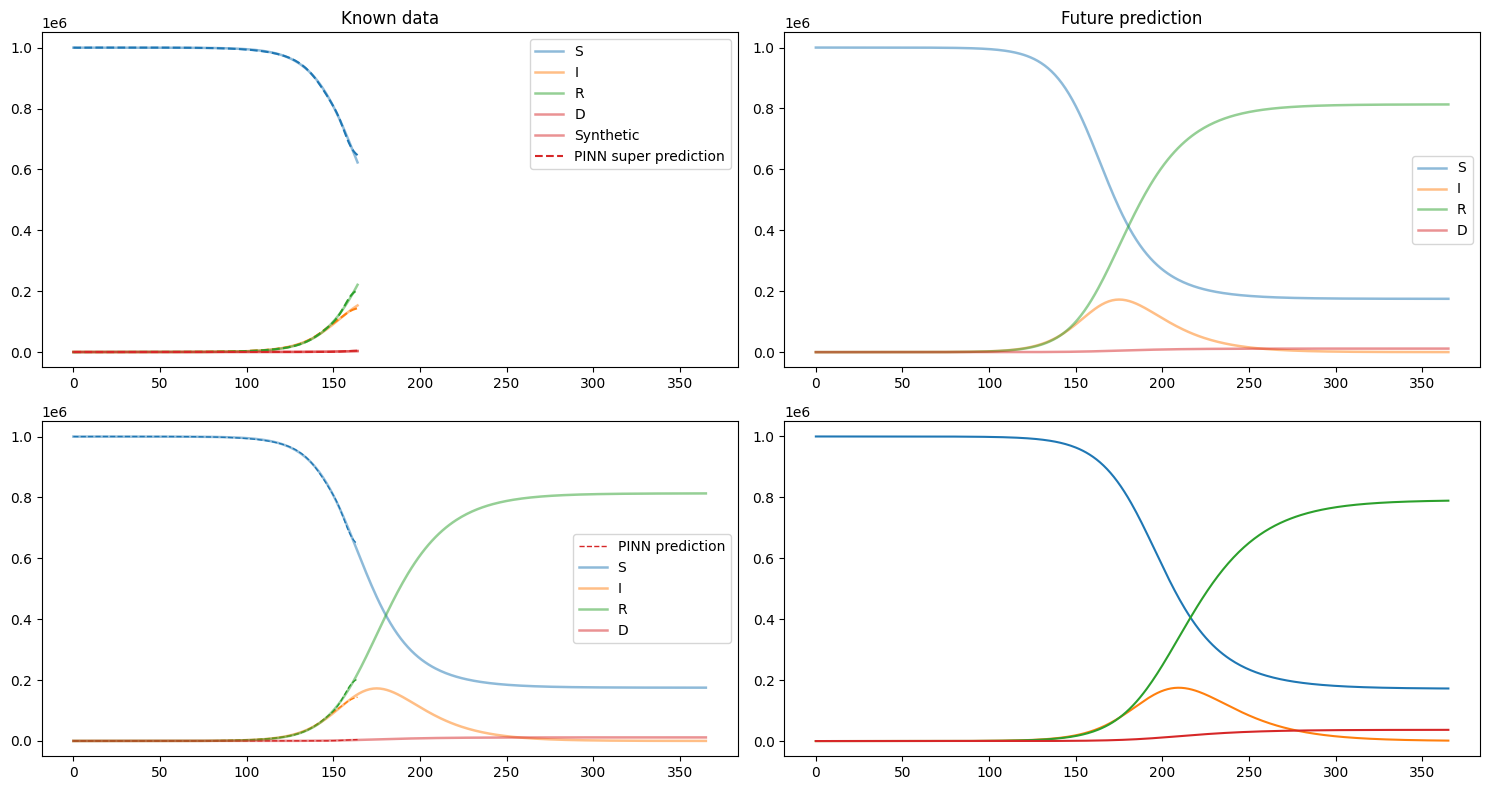

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
196000    [6.64e-06, 8.91e-07, 3.23e-06, 9.28e-09, 5.56e-09, 1.45e-05, 5.73e-06, 7.64e-06, 1.19e-06, 2.17e-05, 0.00e+00, 0.00e+00, 0.00e+00, 5.12e-08, 2.19e-08, 8.44e-09, 4.84e-10, 4.44e-07, 5.51e-08, 1.81e-07, 3.50e-10]    [6.64e-06, 8.91e-07, 3.23e-06, 9.28e-09, 5.56e-09, 1.45e-05, 5.73e-06, 7.64e-06, 1.19e-06, 2.17e-05, 0.00e+00, 0.00e+00, 0.00e+00, 5.12e-08, 2.19e-08, 8.44e-09, 4.84e-10, 4.44e-07, 5.51e-08, 1.81e-07, 3.50e-10]    []  
198000    [3.66e-06, 2.65e-07, 1.94e-06, 5.11e-09, 5.57e-08, 1.75e-06, 3.47e-07, 9.73e-0

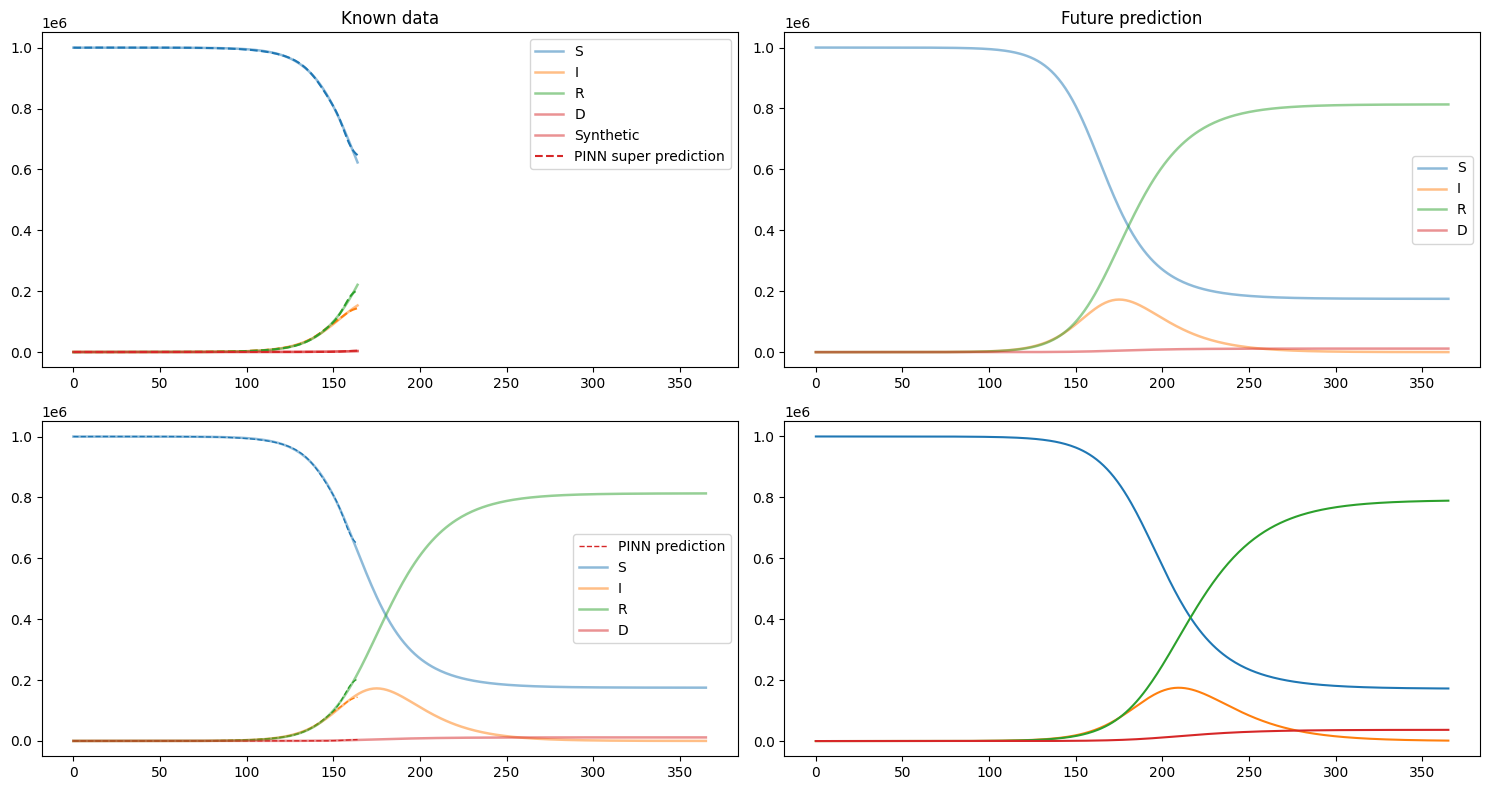

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
296000    [4.40e-06, 3.79e-07, 2.06e-06, 6.07e-08, 1.47e-07, 1.11e-05, 1.69e-06, 7.15e-06, 1.73e-07, 2.28e-06, 0.00e+00, 9.27e-09, 0.00e+00, 2.73e-08, 3.25e-08, 2.57e-16, 1.69e-10, 5.86e-06, 1.18e-06, 1.65e-06, 1.52e-10]    [4.40e-06, 3.79e-07, 2.06e-06, 6.07e-08, 1.47e-07, 1.11e-05, 1.69e-06, 7.15e-06, 1.73e-07, 2.28e-06, 0.00e+00, 9.27e-09, 0.00e+00, 2.73e-08, 3.25e-08, 2.57e-16, 1.69e-10, 5.86e-06, 1.18e-06, 1.65e-06, 1.52e-10]    []  
298000    [5.79e-07, 1.38e-07, 2.18e-07, 6.48e-09, 1.47e-05, 1.79e-04, 2.33e-05, 5.31e-0

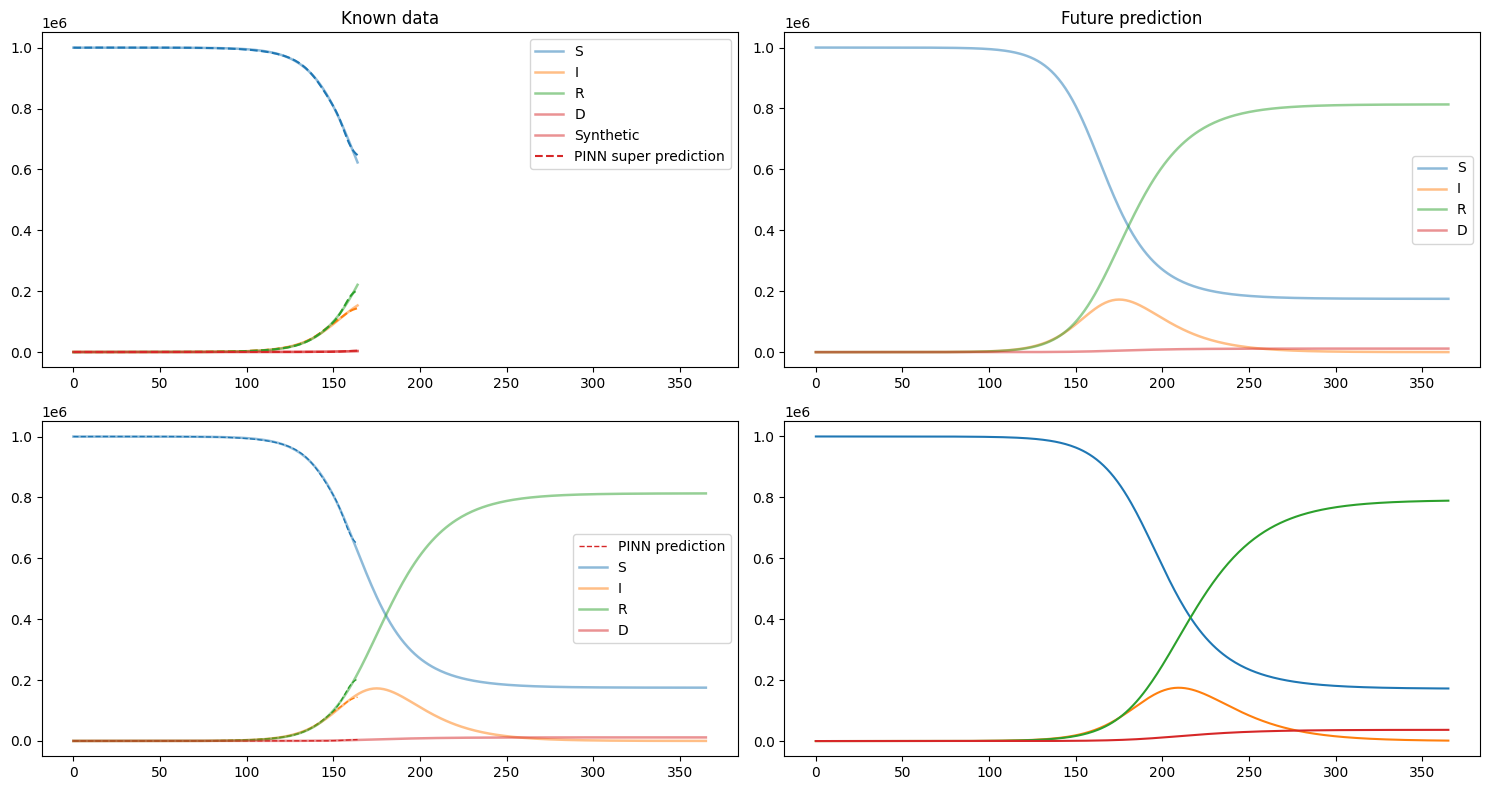

In [ ]:
intermediate_train()

Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
396000    [8.27e-06, 2.03e-06, 2.67e-06, 1.94e-08, 7.00e-06, 7.19e-05, 4.57e-05, 8.10e-05, 2.26e-05, 1.89e-04, 0.00e+00, 0.00e+00, 0.00e+00, 5.01e-11, 9.33e-12, 1.44e-11, 1.52e-16, 2.87e-07, 5.35e-08, 8.22e-08, 4.14e-12]    [8.27e-06, 2.03e-06, 2.67e-06, 1.94e-08, 7.00e-06, 7.19e-05, 4.57e-05, 8.10e-05, 2.26e-05, 1.89e-04, 0.00e+00, 0.00e+00, 0.00e+00, 5.01e-11, 9.33e-12, 1.44e-11, 1.52e-16, 2.87e-07, 5.35e-08, 8.22e-08, 4.14e-12]    []  
398000    [5.32e-06, 5.30e-07, 2.45e-06, 5.82e-09, 8.80e-11, 4.76e-06, 1.51e-06, 3.96e-0

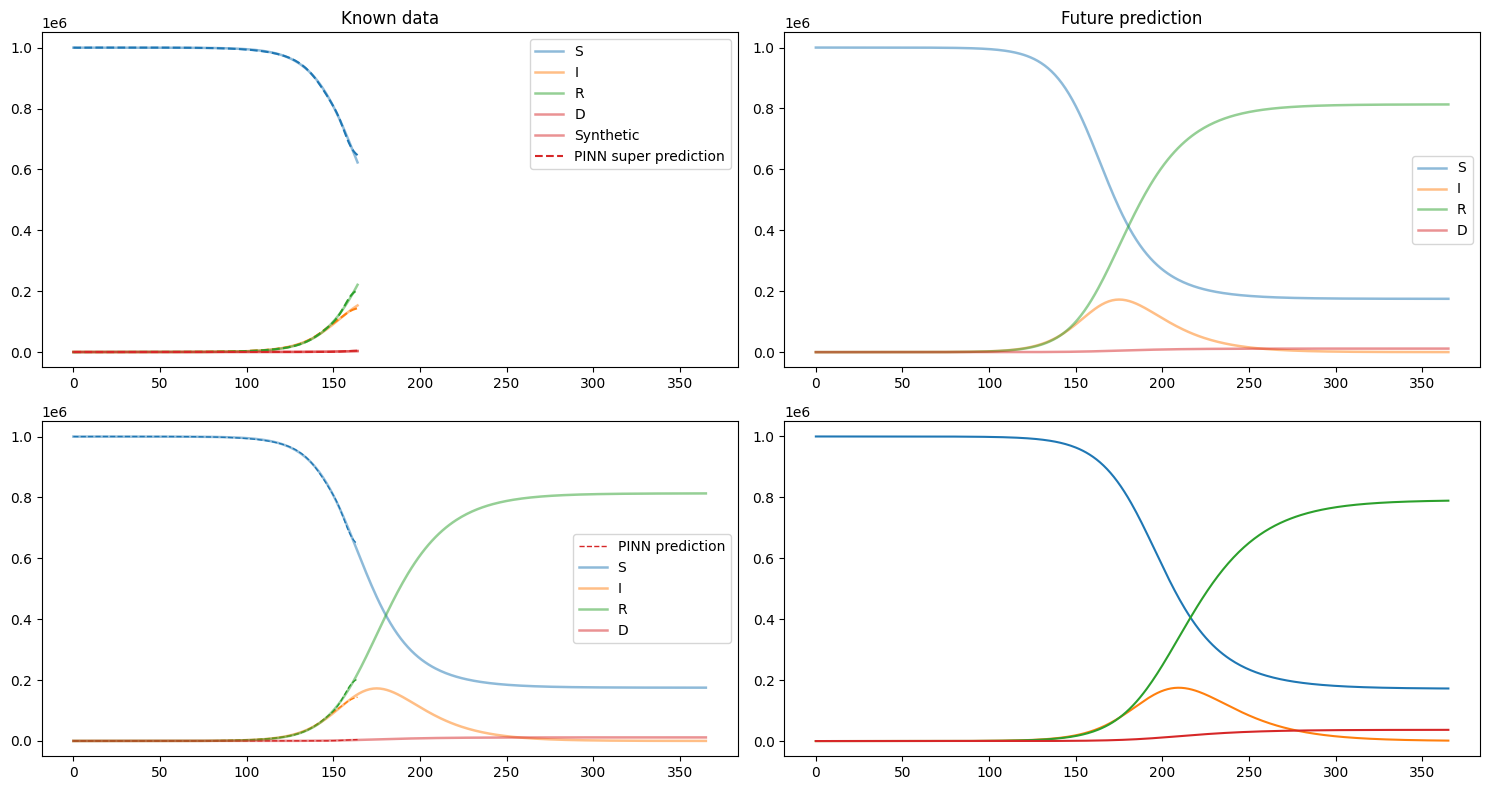

In [ ]:
intermediate_train()

# Final Output 

In [ ]:
# params_nn, best_step = model.get_best_params(out_func=np.exp) # parameters need to be extracted with the exponential functino as they have been modelled in logspace
params_nn, best_step = model.get_best_params() # parameters need to be extracted with the exponential functino as they have been modelled in logspace
print(static_parameters, sep="\n")
t_nn_param, wsol_nn_param, wsol_sird_nn_param = solver(*params_nn)

model.set_synthetic_data(t_synth, solution_synth_full) 
model.set_nn_synthetic_data(t_nn_param, wsol_nn_param, wsol_sird_nn_param)
plot = Plot(model, values_to_plot=sird_model.initial_conditions_keys) # class that contains plotting functions
# plot.show_known_and_prediction()
# plot.plot_param_history()
# plot.plot_loss_history()

Best train step: 195362
alpha: 0.12480357289
beta: 0.056060258299
gamma: 0.0026137018576
{'alpha': 0.15, 'beta': 0.07, 'gamma': 0.001}


/Users/jhh/Library/Mobile Documents/com~apple~CloudDocs/DTU/11Semester Msc/Deep Learning/Deep_Learning_Project_PINN/exercises_Jakob/Plot.py:290: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/jhh/Library/Mobile Documents/com~apple~CloudDocs/DTU/11Semester Msc/Deep Learning/Deep_Learning_Project_PINN/.venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


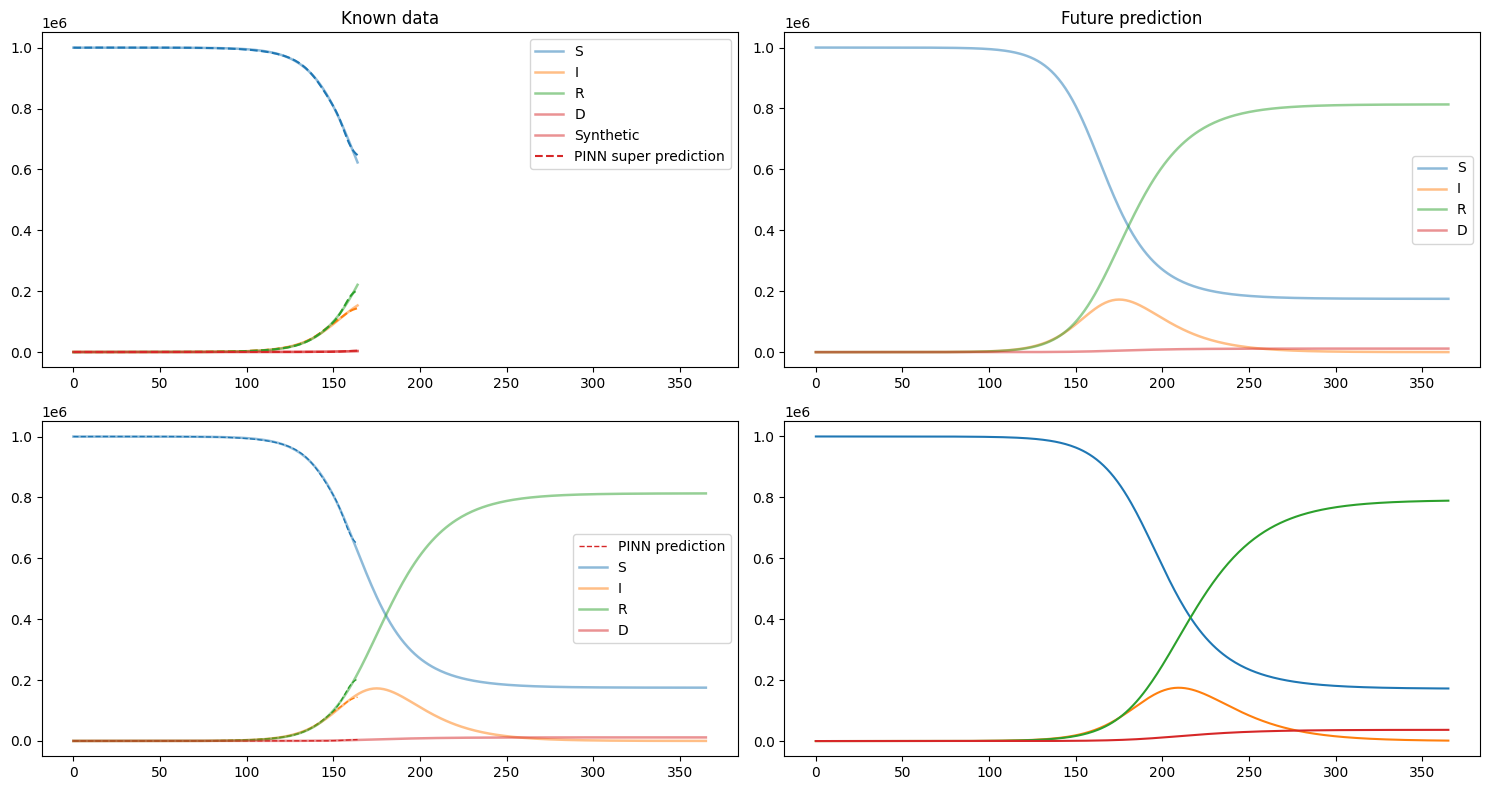

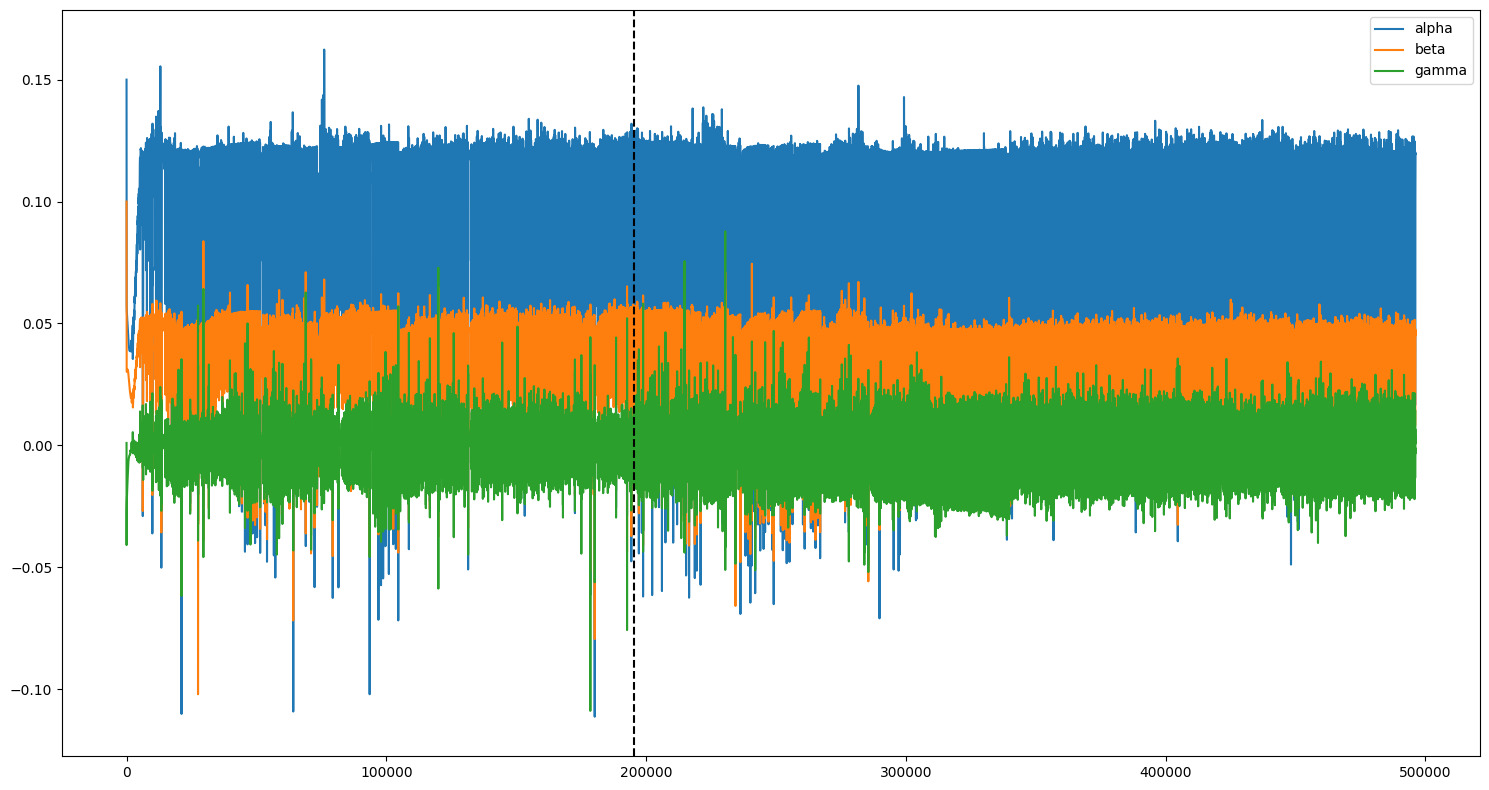

/Users/jhh/Library/Mobile Documents/com~apple~CloudDocs/DTU/11Semester Msc/Deep Learning/Deep_Learning_Project_PINN/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


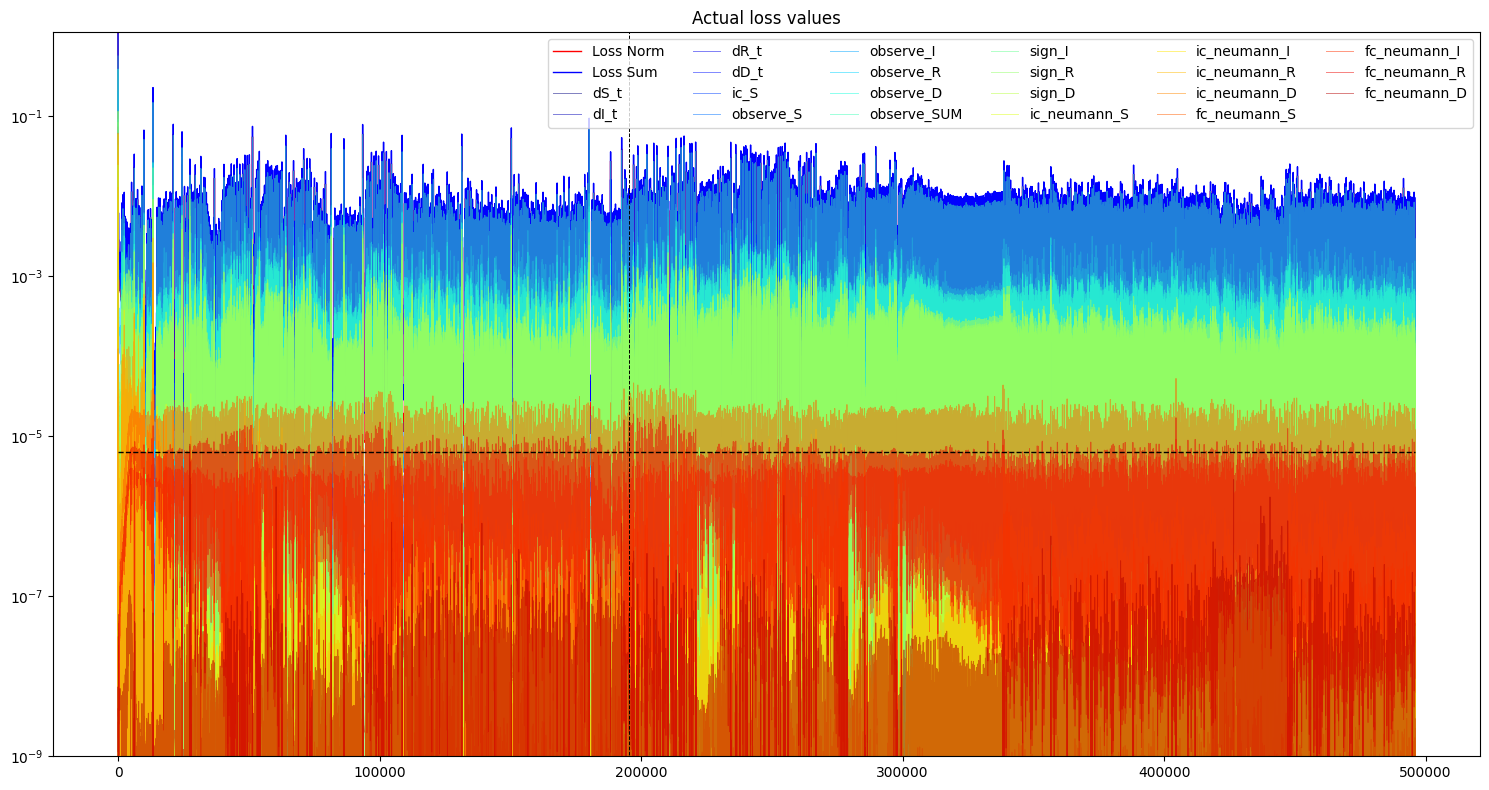

In [ ]:
plot.show_known_and_prediction()
plot.plot_param_history()
plot.plot_loss_history()

In [ ]:
# from SIRD_normal_nn import SIRD_net
# max_timestep = 100000
# t_bool = t_synth < max_timestep
# t = t_synth[t_bool]
# wsol = solution_synth[t_bool]

# net = SIRD_net(t, wsol, init_num_people=1e6)
# net.train()
# net.plot(t_synth, solution_synth)

In [ ]:
# fig, ax = plt.subplots()
# net.plot(ax, t_synth)